# fill missing values with knn

- 0620에 정한 하이퍼파라미터로 진행
- 좀 더 명확하고 간결한 모듈화
    - str -> int로 바꾸는 것을 전처리 단계에서 진행
    - metric 함수에서 외부의 변수는 최대한 사용하지 않는 방향으로 변경

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import missingno as msno
import seaborn as sns 
import os

In [2]:
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("fivethirtyeight")
# 이미지가 레이아웃 안으로 들어오도록 함
mpl.rcParams.update({"figure.constrained_layout.use": True})

In [3]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
[fm.FontProperties(fname=font).get_name() for font in font_list if 'D2C' in font]
plt.rc('font', family='D2Coding')
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
DATASET_DIR = '/home/doeun/code/AI/ESTSOFT2024/workspace/dataset/'
load_dir = 'america_big_cities_health_inventory'
file_name = 'BigCitiesHealth.csv'
RSLT_DIR = '/home/doeun/code/AI/ESTSOFT2024/workspace/1.project1_structured/BCHI/processed/'
pvtb_dir = RSLT_DIR + 'pvtb/'

## FUNCTIONS

- preprocess

In [5]:
def count_key_opt(data:pd.DataFrame,key,opt):
    rslt = dict()
    labels = data[key].unique()
    form = data[opt].value_counts().sort_values(ascending=False)
    form.iloc[:] = 0

    for feat in labels:
        cond = data[key]==feat
        val = form.copy()
        temp = data.loc[cond,opt].value_counts()
        val.loc[temp.index] = temp
        rslt[feat] = val

    return pd.DataFrame(rslt).T

In [6]:
import functools

def cond_check_dict(data=pd.DataFrame,val_dict=dict):
    cond_list=[
        data[col] == val
        for col, val in val_dict.items()
    ]
    return functools.reduce(lambda x,y: x & y, cond_list)

- plot

In [7]:
import re

def choose_split_point(word_len,space,ths):
    # 윗 줄에 space 만큼 공백이 있고, 한 줄의 길이가 ths로 제한 되어있을 때
    # 어떤 지점에서 단어를 끊어줄지 정하기
    # |-------ths-------|
    # |-space-|---------|-space-|------| : word
    #         |-------ths-------|
    print(word_len,space,ths)
    if word_len < ths + space :
        if abs(word_len/2 -ths) <= abs(word_len/2-space) :
            return word_len-ths
        else :
            return word_len - space if word_len < 2 * space else space
    else :
        return ths if word_len - (ths + space) < 0.3 * ths else space

def minimize_seq_idx_np(domain:np.array,func):
    vfunc = np.vectorize(func)
    temp = np.argsort(vfunc(domain))
    return temp[0]

def modify_strlen_ths(last,new,ths=16):
    front = len(last)
    space = ths - (1+front)
    if len(new) < space :
        rslt = [last + ' ' + new]
    else :
        if len(new) < ths:
            rslt = [last, new]
        else:
            cut = choose_split_point(len(new),space-1,ths-1)
            new_h, new_e = new[:cut]+'-', new[cut:]
            if cut < ths-1 :
                rslt = modify_strlen_ths(last+' '+new_h,new_e)
            else :
                rslt = [last] + modify_strlen_ths(new_h,new_e) 
    return rslt

def str_cutter(sentnc, ths = 16):
    words= sentnc.split(' ')
    rslt, pnt = [''], 0
    while pnt < len(words):
        last = '' if len(rslt)==0 else rslt[-1]
        next_ele = modify_strlen_ths(last,words[pnt],ths)
        rslt = rslt[:-1] + next_ele
        pnt += 1
    return '\n'.join(rslt)[1:]
#알고리즘 때문에 맨 앞에 빈칸 하나 들어가게 되는 이슈 있음

print(str_cutter('Racial Segregation Indices | Racial Segregation, White and Hispanic', 13))



Racial
Segregation
Indices |
Racial
Segregation,
White and
Hispanic


In [8]:
def choose_plot_grid(n:int,r_max=8,c_max=17,res_ths=2):
    #ver2
    r_min = np.ceil(n/c_max)
    sppt = np.arange(r_min,r_max+1) #need error process
    col_nums = np.ceil(n/sppt)
    res = col_nums * sppt -n
    min_idx = np.where((res==np.min(res)) | (res <= res_ths))[0]
    row_cand, col_cand = sppt[min_idx], col_nums[min_idx]
    if len(min_idx) > 1 :
        res = np.abs(row_cand-col_cand)
        i = np.where(res==np.min(res))[0][0]
    else : i = 0
    return int(row_cand[i]), int(col_cand[i])


def pair_plot_feat_hue(fig,axes,data:dict,pair_plot,axis_share=False,hue_label_dict=None, **kwargs):
    #ver2
    if (fig is None) or (axes is None) :
        num_r, num_c = choose_plot_grid(len(data))
        fig, axes = plt.subplots(num_r,num_c,figsize=(21,17),sharex=axis_share,sharey=axis_share)
    for n,key in enumerate(data.keys()):
        ax = axes.flatten()[n]
        plt.setp(ax.get_xticklabels(),ha = 'left',rotation = 90)
        if n >= len(data) : continue
        pair_plot(x=data[key][0], y = data[key][1],ax =ax, **kwargs)
        feat_name = str(key) 
        if hue_label_dict: color = 'b' if hue_label_dict[feat_name] else 'k'
        else : color = 'k'
        ax.set_xlabel(str_cutter(feat_name,20),loc='left',fontsize = 8.3,color=color)
    return fig,axes

In [9]:
choose_plot_grid(5)

(2, 3)

# preprocess

- add geo_strat_info
- encoding str data
- select labels 

#### 1. Load Data

In [10]:
pvtb_name = 'pvtb_city_entire_ver0.csv'
pvtb_path = os.path.join(pvtb_dir,pvtb_name)
pvtb_entire = pd.read_csv(pvtb_path)

In [15]:
geo_name = 'geo_strat_info.csv'
geo_info_path = os.path.join(RSLT_DIR,geo_name)
geo_strat_info = pd.read_csv(geo_info_path, index_col=0)

In [16]:
pvtb_name = 'pvtb_city_encoded_ver1.csv'
pvtb_encoded = pd.read_csv(os.path.join(RSLT_DIR,pvtb_dir,pvtb_name),index_col=0)
pvtb_encoded

,geo_label_city,encoded_strata_race_label,encoded_strata_sex_label,encoded_geo_strata_region,encoded_geo_strata_poverty,encoded_geo_strata_Population,encoded_geo_strata_PopDensity,encoded_geo_strata_Segregation,date_label,Active Transportation | Riding Bike to Work,...,Substance Use | Adult Smoking,Substance Use | Drug Overdose Deaths,Substance Use | Opioid Overdose Deaths,Substance Use | Teen Alcohol,Substance Use | Teen Marijuana,Substance Use | Teen Smoking,Transportation | Drives Alone to Work,Transportation | Lack of Car,Transportation | Longer Driving Commute Time,Transportation | Public Transportation Use
0,Austin,0,0,2,1,0,0,0,2010,1.458997,...,14.1,14.814379,5.316296,NaN,NaN,NaN,71.701852,7.104797,NaN,4.673879
1,Austin,0,1,2,1,0,0,0,2010,NaN,...,NaN,12.110401,4.224056,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Austin,0,2,2,1,0,0,0,2010,NaN,...,NaN,17.451652,6.417004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Austin,4,0,2,1,0,0,0,2010,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Austin,4,1,2,1,0,0,0,2010,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7275,Washington,3,2,2,1,0,1,1,2022,NaN,...,NaN,25.584642,21.067009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7276,Washington,5,0,2,1,0,1,1,2022,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19.237013,NaN,NaN,38.879870
7277,Washington,1,0,2,1,0,1,1,2022,NaN,...,NaN,13.498547,8.887272,NaN,NaN,NaN,24.173919,NaN,NaN,21.684225
7278,Washington,1,1,2,1,0,1,1,2022,NaN,...,NaN,6.485127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
import itertools

entire_region = [ "Midwest", "Northeast", "South", "West" ]
region_adjacent = [
    { "Midwest", "Northeast" },
    { "Midwest", "South" },
    { "Midwest", "West" },
    { "West", "South" },
    { "South", "Northeast" }
]
encode_region ={
    "Midwest": 0,
    "Northeast": 1,
    "South": 2,
    "West": 3 
}

entire_race = ['All','White','Black','Hispanic','Asian/PI','Natives']
race_adjacent = [
    {'All', a}
    for a in entire_race
    if a != 'All'
]
encode_race={
    'All' : 0,
    'White' : 1,
    'Black' : 2,
    'Hispanic' : 3,
    'Asian/PI' : 4,
    'Natives' : 5,
}

entire_sex = ['Both','Female','Male']
sex_adjacent = [
    {'Both', a}
    for a in entire_sex
    if a != 'Both'
]
encode_sex = {
    'Both' : 0,
    'Female' : 1,
    'Male' : 2,
}

encode_poverty = {
    'Poorest cities (18%+ poor)' : 0,
    'Less poor cities (<18% poor)' : 1,
}
encode_pop = {
    'Smaller (<1.3 million)' : 0,
    'Largest (>1.3 million)' : 1,
}
encode_popdensity = {
    'Lower pop. density (<10k per sq mi)' : 0,
    'Highest pop. density (>10k per sq mi)' : 1,
}
encode_segregation = {
    'Less Segregated (<50%)' : 0,
    'Highly Segregated (50%+)' : 1,
}


encode_dict ={
    'strata_race_label': encode_race,
    'strata_sex_label': encode_sex,
    'geo_strata_region' : encode_region,
    'geo_strata_poverty' : encode_poverty,
    'geo_strata_Population' : encode_pop,
    'geo_strata_PopDensity' : encode_popdensity,
    'geo_strata_Segregation' : encode_segregation,
}

In [18]:
geo_strat_cols = [
    'geo_strata_region' ,
    'geo_strata_poverty' ,
    'geo_strata_Population' ,
    'geo_strata_PopDensity' ,
    'geo_strata_Segregation' ,
]

### metric on support $X$
##### **metric on each columns**

basically,
- if a,b are adjacent : d(a,b) = 1
- if minimal path == 2 : d(a,b) = 1.732 (cf. sqrt 3)

In [19]:
def metric_on_adj(points,adjacents,far_distance = 1.732):
    metric_dict=dict()
    for a,b in itertools.product(points,repeat=2):
        if a == b : metric_dict[(a,b)] = 0
        elif {a,b} in adjacents : metric_dict[(a,b)] = 1
        else : metric_dict[(a,b)] = far_distance 
    return lambda x,y : metric_dict[(x,y)]

def metric_binary(x,y):
    return 0 if x==y else 1

In [20]:
def encoding_adj(encode_info,adjacents):
    return [
        set(map(lambda x : encode_info[x],ele))
        for ele in adjacents
    ]

- function test

In [21]:
encoding_adj(encode_sex,sex_adjacent)

[{0, 1}, {0, 2}]

In [22]:
encoded_metric_dict = {
    'strata_race_label': metric_on_adj(range(len(entire_race)),
                                       encoding_adj(encode_race,race_adjacent)),
    'strata_sex_label': metric_on_adj(range(len(entire_sex)),
                                      encoding_adj(encode_sex,sex_adjacent)),
    'geo_strata_region' : metric_on_adj(range(len(entire_region)),
                                        encoding_adj(encode_region,region_adjacent)),
    'geo_strata_poverty' : metric_binary,
    'geo_strata_Population' : metric_binary,
    'geo_strata_PopDensity' : metric_binary,
    'geo_strata_Segregation' : metric_binary,
}

- function test

In [23]:
encoded_metric_dict['strata_race_label'](0,2)

1

In [24]:
encoded_metric_dict['strata_sex_label'](0,0)

0

##### **metric on whole support $X$**

**distance between cities** 
- 각 axis 에서의 거리를 L7 norm 한 것으로 테스트
- 7은 임의로 정한 것으로 필요시 다른 값으로 테스트 해봐도 좋을 듯

In [25]:

def metric_btwn_city_info(X,Y):
    info_dict = {
        0 : 'geo_strata_region',
        1 : 'geo_strata_poverty',
        2 : 'geo_strata_Population',
        3 : 'geo_strata_PopDensity',
        4 : 'geo_strata_Segregation',
    }
    diff = [
        encoded_metric_dict[info_dict[i]](x,y)
        for i, (x,y) in enumerate(zip(X,Y))
    ]
    return np.linalg.norm(np.array(diff),ord=7)

- function test

In [26]:
X = pvtb_encoded.loc[0,list(map(lambda x : 'encoded_'+x,geo_strat_cols))]
Y = pvtb_encoded.loc[340,list(map(lambda x : 'encoded_'+x,geo_strat_cols))]

metric_btwn_city_info(X,Y)

1.1040895136738123

In [27]:
pvtb_encoded.loc[0,'geo_label_city'], pvtb_encoded.loc[340,'geo_label_city']

('Austin', 'Baltimore')

- 프로토타입 기간 동안 학습 속도 향상을 위해 도시 간 거리로 정리해 놓는 것도 방법
- 도시간 거리 metric dict를 pkl or csv로 저장해두고 불러와서 쓰는 것도 고려 필요

In [28]:
list(pvtb_encoded.columns)[1:9]

['encoded_strata_race_label',
 'encoded_strata_sex_label',
 'encoded_geo_strata_region',
 'encoded_geo_strata_poverty',
 'encoded_geo_strata_Population',
 'encoded_geo_strata_PopDensity',
 'encoded_geo_strata_Segregation',
 'date_label']

**distance between points** 
- 각 속성 에서의 거리를 L5 norm 한 것으로 테스트
- 5은 임의로 정한 것으로 필요시 다른 값으로 테스트 해봐도 좋을 듯

In [29]:
a = np.arange(2,6)
a

array([2, 3, 4, 5])

In [30]:
a[[1]]

array([3])

- function test

In [31]:
X = pvtb_encoded.iloc[0,range(1,9)]
Y = pvtb_encoded.iloc[340,range(1,9)]

X,Y

(encoded_strata_race_label            0
 encoded_strata_sex_label             0
 encoded_geo_strata_region            2
 encoded_geo_strata_poverty           1
 encoded_geo_strata_Population        0
 encoded_geo_strata_PopDensity        0
 encoded_geo_strata_Segregation       0
 date_label                        2010
 Name: 0, dtype: object,
 encoded_strata_race_label            4
 encoded_strata_sex_label             1
 encoded_geo_strata_region            2
 encoded_geo_strata_poverty           0
 encoded_geo_strata_Population        0
 encoded_geo_strata_PopDensity        0
 encoded_geo_strata_Segregation       1
 date_label                        2018
 Name: 340, dtype: object)

- vector function

In [32]:
# example

def g(x,p):
  return p[0]+x*p[1]+x*x*p[2]

print(g(5,[0,0,1]))

vg = np.vectorize(g, excluded=['p'])
print(vg(x=[0,1,2,3,4,5],p=[0,1,2])) 

25
[ 0  3 10 21 36 55]


In [33]:
vec_metric_dict={
    key : np.vectorize(val)
    for key,val in encoded_metric_dict.items()
}


In [34]:
def metric_btwn_city_info_for_vec(X,Y):
    diff = [
        vec_metric_dict['geo_strata_region'](int(X[0]),int(Y[0])),
        vec_metric_dict['geo_strata_poverty'](int(X[1]),int(Y[1])),
        vec_metric_dict['geo_strata_Population'](int(X[2]),int(Y[2])),
        vec_metric_dict['geo_strata_PopDensity'](int(X[3]),int(Y[3])),
        vec_metric_dict['geo_strata_Segregation'](int(X[4]),int(Y[4])),
    ]
    return np.linalg.norm(np.array(diff),ord=7)

vec_metric_dict['city_info'] = np.vectorize(metric_btwn_city_info_for_vec,excluded={0,1})

In [35]:
X = pvtb_encoded.iloc[0,range(3,8)]
Y = pvtb_encoded.iloc[340,range(3,8)]
X, Y

(encoded_geo_strata_region         2
 encoded_geo_strata_poverty        1
 encoded_geo_strata_Population     0
 encoded_geo_strata_PopDensity     0
 encoded_geo_strata_Segregation    0
 Name: 0, dtype: object,
 encoded_geo_strata_region         2
 encoded_geo_strata_poverty        0
 encoded_geo_strata_Population     0
 encoded_geo_strata_PopDensity     0
 encoded_geo_strata_Segregation    1
 Name: 340, dtype: object)

In [36]:
vec_metric_dict['city_info'](X,Y)

1.1040895136738123

In [37]:
weight_norm = np.array([0.5,0.5,0.4,0.1])

def weigted_metric_spprt(vec_metric,X,Y):
    city_idx= range(2,7)
    race_idx, sex_idx, date_idx = 0, 1, 7
    diff = [
        vec_metric['strata_race_label'](int(X[race_idx]),int(Y[race_idx])),
        vec_metric['strata_sex_label'](int(X[sex_idx]),int(Y[sex_idx])),
        vec_metric['city_info'](X[city_idx],Y[city_idx]),
        np.abs(X[date_idx]-Y[date_idx]),
            ]
    return np.linalg.norm(np.array(diff)*weight_norm,ord=5)

vec_weighted_metric_spprt= np.vectorize(lambda x,y : weigted_metric_spprt(vec_metric_dict,x,y),excluded={0,1})
#함수 내에서 쓰인 외부의 변수들도 decompose하려고 하기 때문에, city_list 등을 모두 exclude 해야 작동함

In [38]:
X = pvtb_encoded.iloc[0,range(1,9)]
Y = pvtb_encoded.iloc[340,range(1,9)]
X.to_numpy(),Y.to_numpy()

(array([0, 0, 2, 1, 0, 0, 0, 2010], dtype=object),
 array([4, 1, 2, 0, 0, 0, 1, 2018], dtype=object))

In [39]:
vec_weighted_metric_spprt(X.to_numpy(),Y.to_numpy())

0.8354389388940956

- vectorize가 된 것이 맞는지...? 속도 개선이 되는 건지...?
- jit 사용하는 쪽 고려

-속도 문제로 city간의 metric을 미리 계산

In [40]:
pvtb_encoded

,geo_label_city,encoded_strata_race_label,encoded_strata_sex_label,encoded_geo_strata_region,encoded_geo_strata_poverty,encoded_geo_strata_Population,encoded_geo_strata_PopDensity,encoded_geo_strata_Segregation,date_label,Active Transportation | Riding Bike to Work,...,Substance Use | Adult Smoking,Substance Use | Drug Overdose Deaths,Substance Use | Opioid Overdose Deaths,Substance Use | Teen Alcohol,Substance Use | Teen Marijuana,Substance Use | Teen Smoking,Transportation | Drives Alone to Work,Transportation | Lack of Car,Transportation | Longer Driving Commute Time,Transportation | Public Transportation Use
0,Austin,0,0,2,1,0,0,0,2010,1.458997,...,14.1,14.814379,5.316296,NaN,NaN,NaN,71.701852,7.104797,NaN,4.673879
1,Austin,0,1,2,1,0,0,0,2010,NaN,...,NaN,12.110401,4.224056,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Austin,0,2,2,1,0,0,0,2010,NaN,...,NaN,17.451652,6.417004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Austin,4,0,2,1,0,0,0,2010,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Austin,4,1,2,1,0,0,0,2010,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7275,Washington,3,2,2,1,0,1,1,2022,NaN,...,NaN,25.584642,21.067009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7276,Washington,5,0,2,1,0,1,1,2022,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19.237013,NaN,NaN,38.879870
7277,Washington,1,0,2,1,0,1,1,2022,NaN,...,NaN,13.498547,8.887272,NaN,NaN,NaN,24.173919,NaN,NaN,21.684225
7278,Washington,1,1,2,1,0,1,1,2022,NaN,...,NaN,6.485127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
geo_strat_info

,geo_label_state,geo_label_citystate,geo_strata_region,geo_strata_poverty,geo_strata_Population,geo_strata_PopDensity,geo_strata_Segregation,count
geo_label_city,,,,,,,,
New York City,NY,"New York City, NY",Northeast,Less poor cities (<18% poor),Largest (>1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),6535
Houston,TX,"Houston, TX",South,Poorest cities (18%+ poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),6431
Los Angeles,CA,"Los Angeles, CA",West,Less poor cities (<18% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),6372
Philadelphia,PA,"Philadelphia, PA",Northeast,Poorest cities (18%+ poor),Largest (>1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),6310
San Diego,CA,"San Diego, CA",West,Less poor cities (<18% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),6251
Chicago,IL,"Chicago, IL",Midwest,Less poor cities (<18% poor),Largest (>1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),6210
San Francisco,CA,"San Francisco, CA",West,Less poor cities (<18% poor),Smaller (<1.3 million),Highest pop. density (>10k per sq mi),Less Segregated (<50%),6121
Las Vegas,NV,"Las Vegas, NV",West,Less poor cities (<18% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),5848
Boston,MA,"Boston, MA",Northeast,Less poor cities (<18% poor),Smaller (<1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),5718


In [42]:
dict_metric = {
    'strata_race_label': metric_on_adj(entire_race,race_adjacent),
    'strata_sex_label': metric_on_adj(encode_sex,sex_adjacent),
    'geo_strata_region' : metric_on_adj(encode_region,region_adjacent),
    'geo_strata_poverty' : metric_binary,
    'geo_strata_Population' : metric_binary,
    'geo_strata_PopDensity' : metric_binary,
    'geo_strata_Segregation' : metric_binary,
}

In [43]:
city_list = list(geo_strat_info.index)

metric_val= dict()
for a, b in itertools.product(city_list,repeat=2):
    diff = [
        dict_metric[col](geo_strat_info.loc[a,col],
                         geo_strat_info.loc[b,col])
        for col in geo_strat_cols
        ]
    metric_val[(a,b)] = np.linalg.norm(np.array(diff),ord=7)
    
dict_metric['geo_label_city'] = lambda x,y : metric_val[(x,y)]

In [44]:
weight_norm = np.array([0.5,0.5,0.4,0.1])

def weigted_metric_city(X,Y):
    X_city, Y_city = city_list[int(X[0])], city_list[int(Y[0])]
    race_idx, sex_idx, date_idx = 1, 2, 8
    diff = [
        vec_metric_dict['strata_race_label'](int(X[race_idx]),int(Y[race_idx])),
        vec_metric_dict['strata_sex_label'](int(X[sex_idx]),int(Y[sex_idx])),
        dict_metric['geo_label_city'](X_city,Y_city),
        np.abs(X[date_idx]-Y[date_idx]),
            ]
    return np.linalg.norm(np.array(diff)*weight_norm,ord=5)

In [45]:
pvtb_encoded['city_idx'] = pvtb_encoded['geo_label_city'].apply(lambda x : city_list.index(x))

In [46]:
temp = list(pvtb_encoded.columns)
pvtb_encoded_whole = pvtb_encoded[['city_idx']+temp[1:-1]]
pvtb_encoded_whole

,city_idx,encoded_strata_race_label,encoded_strata_sex_label,encoded_geo_strata_region,encoded_geo_strata_poverty,encoded_geo_strata_Population,encoded_geo_strata_PopDensity,encoded_geo_strata_Segregation,date_label,Active Transportation | Riding Bike to Work,...,Substance Use | Adult Smoking,Substance Use | Drug Overdose Deaths,Substance Use | Opioid Overdose Deaths,Substance Use | Teen Alcohol,Substance Use | Teen Marijuana,Substance Use | Teen Smoking,Transportation | Drives Alone to Work,Transportation | Lack of Car,Transportation | Longer Driving Commute Time,Transportation | Public Transportation Use
0,20,0,0,2,1,0,0,0,2010,1.458997,...,14.1,14.814379,5.316296,NaN,NaN,NaN,71.701852,7.104797,NaN,4.673879
1,20,0,1,2,1,0,0,0,2010,NaN,...,NaN,12.110401,4.224056,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20,0,2,2,1,0,0,0,2010,NaN,...,NaN,17.451652,6.417004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20,4,0,2,1,0,0,0,2010,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20,4,1,2,1,0,0,0,2010,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7275,16,3,2,2,1,0,1,1,2022,NaN,...,NaN,25.584642,21.067009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7276,16,5,0,2,1,0,1,1,2022,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19.237013,NaN,NaN,38.879870
7277,16,1,0,2,1,0,1,1,2022,NaN,...,NaN,13.498547,8.887272,NaN,NaN,NaN,24.173919,NaN,NaN,21.684225
7278,16,1,1,2,1,0,1,1,2022,NaN,...,NaN,6.485127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# KNN regression using metric with city value

In [48]:
from sklearn.neighbors import KNeighborsRegressor
test_cols = [
    'Cancer | All Cancer Deaths',                                
    'Cancer | Lung Cancer Deaths',                               
    'Cancer | Colorectal Cancer Deaths',                         
    'Cardiovascular Disease | Cardiovascular Disease Deaths',    
    'Cardiovascular Disease | Heart Disease Deaths',             
    'Deaths | Deaths from All Causes',                           
    'Deaths | Motor Vehicle Deaths',                             
    'Deaths | Gun Deaths (Firearms)',                            
    'Deaths | Premature Death',                                  
    'Deaths | Injury Deaths',                                    
    'Diabetes and Obesity | Diabetes Deaths',                    
    'Life Expectancy at Birth | Life Expectancy',                
    'Mental Health | Suicide',                                   
    'Respiratory Infection | Pneumonia or Influenza Deaths',     
    'Substance Use | Opioid Overdose Deaths',                    
    'Substance Use | Drug Overdose Deaths',                      
    'Crime Incidents | Homicides',                               
]


In [49]:
pvtb_encoded_whole

,city_idx,encoded_strata_race_label,encoded_strata_sex_label,encoded_geo_strata_region,encoded_geo_strata_poverty,encoded_geo_strata_Population,encoded_geo_strata_PopDensity,encoded_geo_strata_Segregation,date_label,Active Transportation | Riding Bike to Work,...,Substance Use | Adult Smoking,Substance Use | Drug Overdose Deaths,Substance Use | Opioid Overdose Deaths,Substance Use | Teen Alcohol,Substance Use | Teen Marijuana,Substance Use | Teen Smoking,Transportation | Drives Alone to Work,Transportation | Lack of Car,Transportation | Longer Driving Commute Time,Transportation | Public Transportation Use
0,20,0,0,2,1,0,0,0,2010,1.458997,...,14.1,14.814379,5.316296,NaN,NaN,NaN,71.701852,7.104797,NaN,4.673879
1,20,0,1,2,1,0,0,0,2010,NaN,...,NaN,12.110401,4.224056,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20,0,2,2,1,0,0,0,2010,NaN,...,NaN,17.451652,6.417004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20,4,0,2,1,0,0,0,2010,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20,4,1,2,1,0,0,0,2010,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7275,16,3,2,2,1,0,1,1,2022,NaN,...,NaN,25.584642,21.067009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7276,16,5,0,2,1,0,1,1,2022,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19.237013,NaN,NaN,38.879870
7277,16,1,0,2,1,0,1,1,2022,NaN,...,NaN,13.498547,8.887272,NaN,NaN,NaN,24.173919,NaN,NaN,21.684225
7278,16,1,1,2,1,0,1,1,2022,NaN,...,NaN,6.485127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
info_cols = [
    'city_idx',
    'encoded_strata_race_label',
    'encoded_strata_sex_label',
    'encoded_geo_strata_region',
    'encoded_geo_strata_poverty',
    'encoded_geo_strata_Population',
    'encoded_geo_strata_PopDensity',
    'encoded_geo_strata_Segregation',
    'date_label',
]
for ele in info_cols:
    print(ele)

city_idx
encoded_strata_race_label
encoded_strata_sex_label
encoded_geo_strata_region
encoded_geo_strata_poverty
encoded_geo_strata_Population
encoded_geo_strata_PopDensity
encoded_geo_strata_Segregation
date_label


In [51]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [52]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

In [54]:
sample = pvtb_encoded[info_cols+[test_cols[-1]]]
sample_nonan = sample.dropna()
X, y = sample_nonan[info_cols], sample_nonan[test_cols[-1]]


In [55]:
train_X, test_X, train_y, test_y = train_test_split(X,y,
                                                    test_size = 0.2,
                                                    random_state=801) #check how to using stratify option

display(train_X.shape)
display(test_X.shape)
display(train_y.shape)
display(test_y .shape)

(3792, 9)

(948, 9)

(3792,)

(948,)

In [56]:
knn_test = KNeighborsRegressor(n_neighbors=5,weights='distance',metric=weigted_metric_city,algorithm='auto')

In [57]:
knn_test.fit(train_X,train_y)

KNeighborsRegressor(metric=<function weigted_metric_city at 0x7fbdb90c4280>,
                    weights='distance')

In [132]:
y_pred   = knn_test.predict(test_X)

In [133]:
print(np.sqrt(mean_squared_error(y_pred,test_y)))
print(np.sqrt(mean_squared_error([train_y.mean()]*len(test_y),test_y)))
r2_score(test_y,y_pred)

10.363768429062214
20.02567071582174


0.7314339909676966

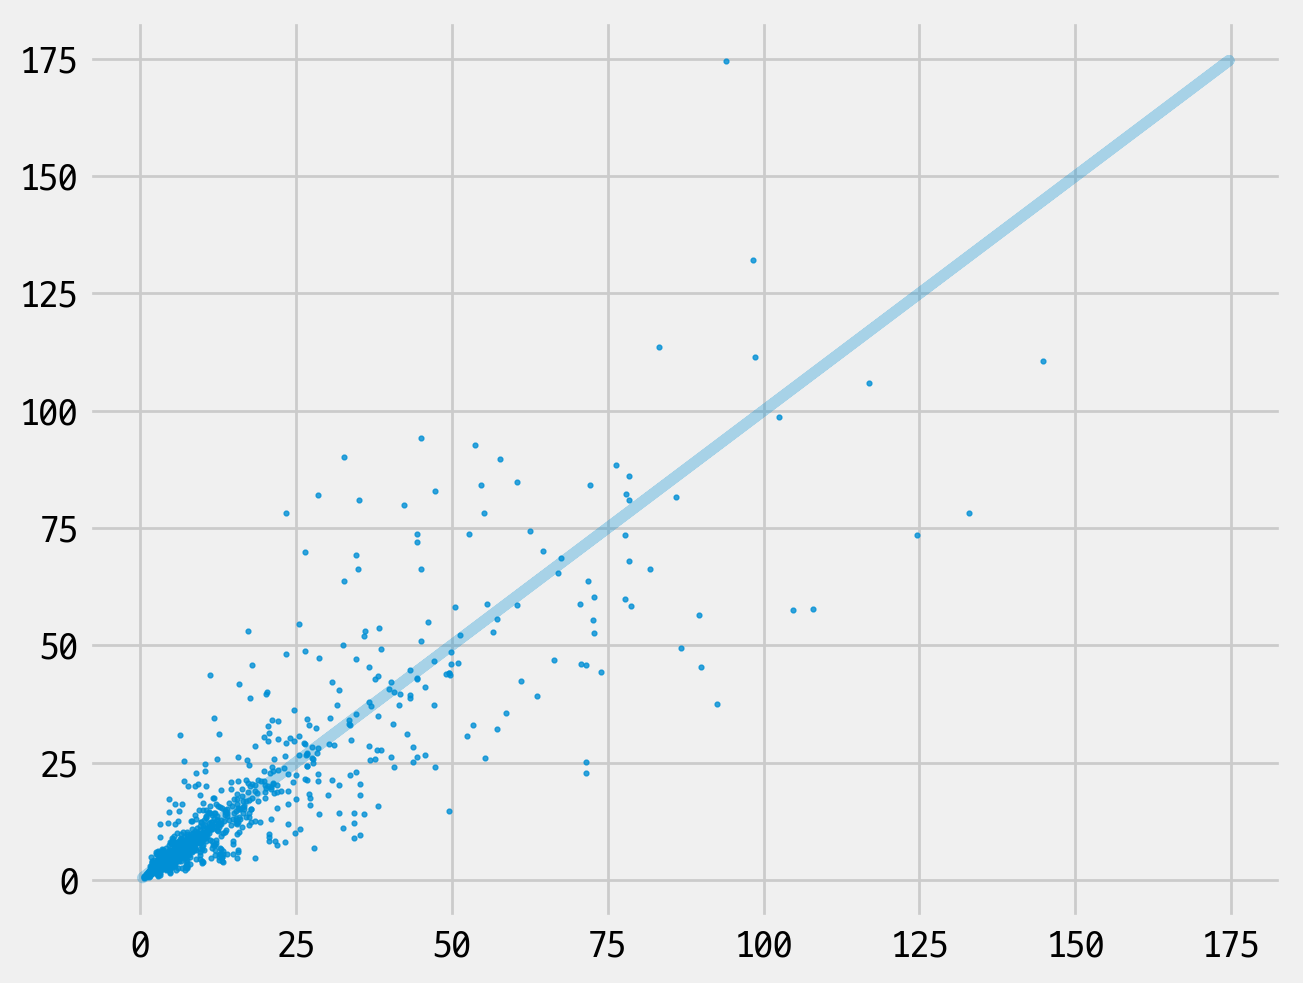

In [134]:
fig,ax = plt.subplots()
ax.plot(test_y,test_y,alpha = 0.3)
ax.scatter(y_pred,test_y,s=3, alpha = 0.8)
pass

15.699234948127636 20.008814450324596


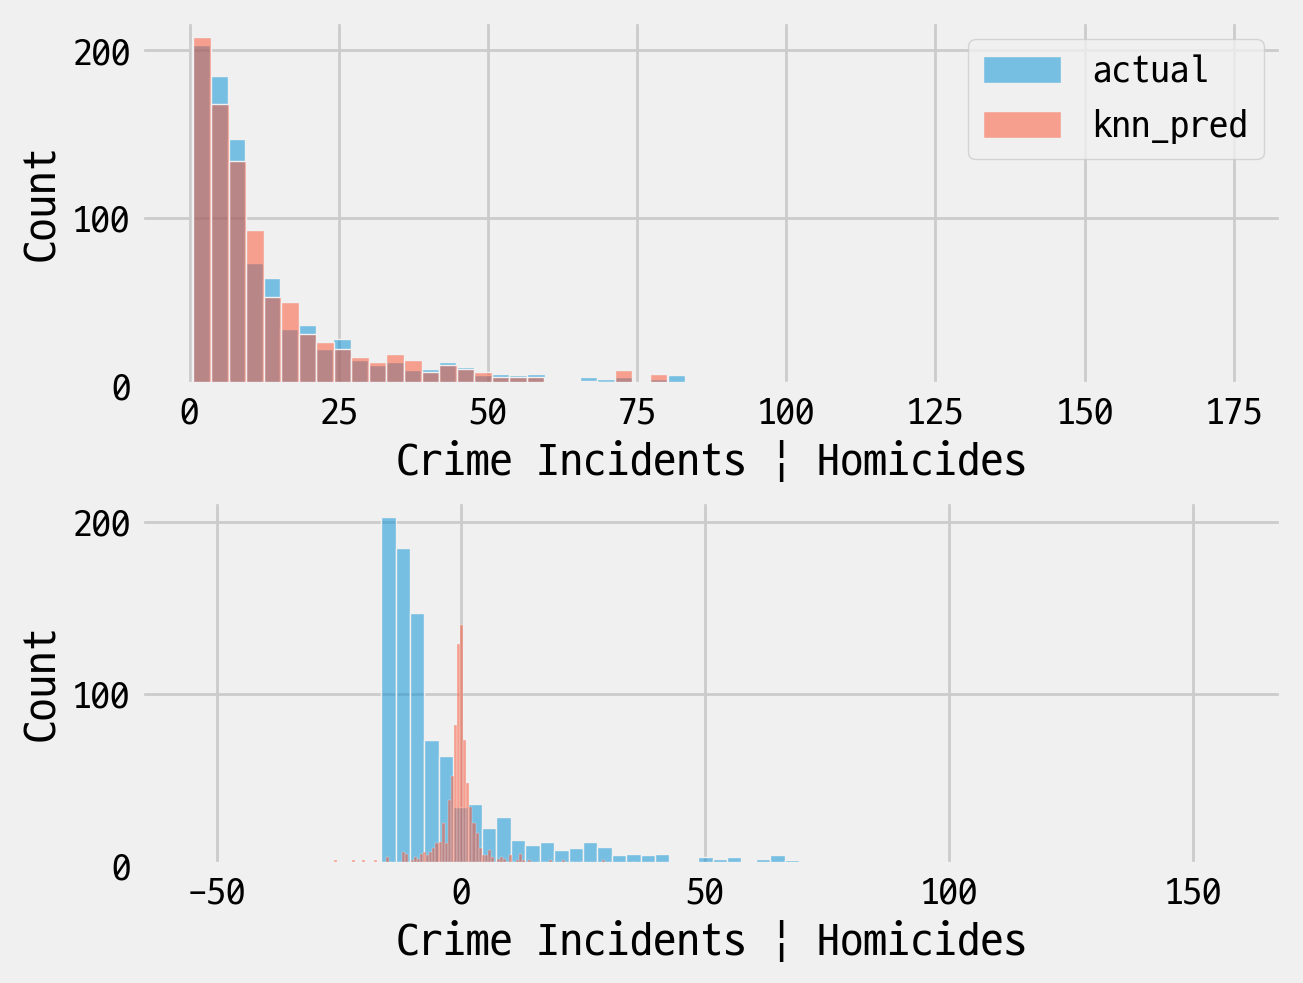

In [135]:
fig,axes = plt.subplots(2,1)
sns.histplot(test_y,label='actual',ax=axes[0],alpha=0.5)
sns.histplot(y_pred,label='knn_pred',ax=axes[0],alpha=0.5)

sns.histplot(test_y-np.mean(train_y),ax=axes[1], label = 'baseline',alpha=0.5)
sns.histplot(test_y-y_pred,ax=axes[1], label = 'knn_pred',alpha=0.5)
axes[0].legend()

print(test_y.mean(),test_y.std())

## filling with knn

In [136]:
col_cand_list=[
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Births | Preterm Births',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Infant Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Income | Per-capita Household Income',
    'Language and Nativity | Primarily Speak English',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Cancer | All Cancer Deaths',
    'Cancer | Breast Cancer Deaths',
    'Cancer | Lung Cancer Deaths',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Language and Nativity | Primarily Speak Spanish',
    'Births | Teen Births',
    'Cancer | All Cancer Deaths',
    'Cancer | Breast Cancer Deaths',
    'Cancer | Lung Cancer Deaths',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Heat and Disasters | Community Social Vulnerability to Climate Disasters',
    'Income-related | Unemployment',
    'Language and Nativity | Primarily Speak Spanish',
    'Mental Health | Suicide',
    'Race/Ethnicity | Minority Population',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Births | Preterm Births',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Infant Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Income | Per-capita Household Income',
    'Language and Nativity | Primarily Speak English',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Births | Preterm Births',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Infant Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Income | Per-capita Household Income',
    'Language and Nativity | Primarily Speak English',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Births | Preterm Births',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Infant Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Income | Per-capita Household Income',
    'Language and Nativity | Primarily Speak English',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Motor Vehicle Deaths',
    'Deaths | Premature Death',
    'Diabetes and Obesity | Diabetes Deaths',
    'Life Expectancy at Birth | Life Expectancy',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Motor Vehicle Deaths',
    'Deaths | Premature Death',
    'Diabetes and Obesity | Diabetes Deaths',
    'Language and Nativity | Foreign Born Population',
    'Life Expectancy at Birth | Life Expectancy',
    'Mental Health | Adult Mental Distress',
    'Racial Segregation Indices | Racial Segregation, White and Non-White',
    'Respiratory Infection | COVID-19 Deaths',
    'Respiratory Infection | New Tuberculosis Cases',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Motor Vehicle Deaths',
    'Deaths | Premature Death',
    'Diabetes and Obesity | Diabetes Deaths',
    'Life Expectancy at Birth | Life Expectancy',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Motor Vehicle Deaths',
    'Deaths | Premature Death',
    'Diabetes and Obesity | Diabetes Deaths',
    'Language and Nativity | Foreign Born Population',
    'Life Expectancy at Birth | Life Expectancy',
    'Mental Health | Adult Mental Distress',
    'Racial Segregation Indices | Racial Segregation, White and Non-White',
    'Respiratory Infection | COVID-19 Deaths',
    'Respiratory Infection | New Tuberculosis Cases',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Premature Death',
    'Life Expectancy at Birth | Life Expectancy',
    'Mental Health | Suicide',
    'Substance Use | Drug Overdose Deaths',
    'Substance Use | Opioid Overdose Deaths',
    'Crime Incidents | Homicides',
    'Deaths | Deaths from All Causes',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Motor Vehicle Deaths',
    'Deaths | Premature Death',
    'Food Access | Limited Supermarket Access',
    'Language and Nativity | Foreign Born Population',
    'Life Expectancy at Birth | Life Expectancy',
    'Mental Health | Suicide',
    'Sexually Transmitted Disease | New Gonorrhea Cases',
    'Substance Use | Drug Overdose Deaths',
    'Substance Use | Opioid Overdose Deaths',
    'Active Transportation | Walking to Work',
    'Deaths | Deaths from All Causes',
    'Deaths | Premature Death',
    'Education | Preschool Enrollment',
    'Lead Poisoning | Child Lead Levels 5+ mcg/dL',
    'Transportation | Public Transportation Use',
    'Active Transportation | Walking to Work',
    'Deaths | Deaths from All Causes',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Infant Deaths',
    'Deaths | Premature Death',
    'Education | Preschool Enrollment',
    'Heat and Disasters | Longer Summers',
    'Income-related | Service Workers',
    'Language and Nativity | Primarily Speak Chinese',
    'Lead Poisoning | Child Lead Levels 5+ mcg/dL',
    'Mental Health | Suicide',
    'Transportation | Public Transportation Use',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Crime Incidents | Homicides',
    'Deaths | Deaths from All Causes',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Injury Deaths',
    'Life Expectancy at Birth | Life Expectancy',
    'Births | Low Birthweight',
    'Births | Preterm Births',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Crime Incidents | Homicides',
    'Crime Incidents | Violent Crime',
    'Deaths | Deaths from All Causes',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Injury Deaths',
    'Deaths | Maternal Deaths',
    'Life Expectancy at Birth | Life Expectancy',
    'Mental Health | Adult Mental Distress',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Deaths from All Causes',
    'Education | College Graduates',
    'Income Inequality | Income Inequality',
    'Lead Poisoning | Housing Lead Risk',
    'Racial Segregation Indices | Racial Segregation, White and Black',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Deaths from All Causes',
    'Deaths | Racial Disparity in Police Killings',
    'Disability | People with Disabilities',
    'Education | College Graduates',
    'Income Inequality | Income Inequality',
    'Income-related | Service Workers',
    'Lead Poisoning | Housing Lead Risk',
    'Population | Single-Parent Families',
    'Race/Ethnicity | Minority Population',
    'Racial Segregation Indices | Racial Segregation, White and Black',
    'Racial Segregation Indices | Racial Segregation, White and Non-White',
    'Active Transportation | Riding Bike to Work',
    'Education | Preschool Enrollment',
    'Housing | Owner Occupied Housing',
    'Population | Population Density',
    'Race/Ethnicity | Minority Population',
    'Racial Segregation Indices | Racial Segregation, White and Black',
    'Active Transportation | Riding Bike to Work',
    'Education | Preschool Enrollment',
    'Housing | Homeless, Total',
    'Housing | Owner Occupied Housing',
    'Housing | Renters vs. Owners',
    'Income Inequality | Income Inequality',
    'Population | Population Density',
    'Race/Ethnicity | Minority Population',
    'Racial Segregation Indices | Racial Segregation, White and Black',
    'Racial Segregation Indices | Racial Segregation, White and Hispanic',
    'Transportation | Lack of Car',
    'Transportation | Longer Driving Commute Time',
    'Deaths | Injury Deaths',
    'Health Insurance | Uninsured, All Ages',
    'Housing | Homeless, Total',
    'Mental Health | Adult Mental Distress',
    'Sexually Transmitted Disease | Syphilis Prevalence',
    'Sexually Transmitted Disease | Syphilis, Newborns',
    'Deaths | Injury Deaths',
    'Health Insurance | Uninsured, All Ages',
    'Health Insurance | Uninsured, Child',
    'Housing | Homeless, Children',
    'Housing | Homeless, Total',
    'Housing | Vacant Housing and Homelessness',
    'Lead Poisoning | Child Lead Levels 5+ mcg/dL',
    'Mental Health | Adult Mental Distress',
    'Population | Children',
    'Sexually Transmitted Disease | Syphilis Prevalence',
    'Sexually Transmitted Disease | Syphilis, Newborns',
]

In [137]:
target_cols = list(set(col_cand_list))
len(target_cols)

67

In [58]:
test_cols

['Cancer | All Cancer Deaths',
 'Cancer | Lung Cancer Deaths',
 'Cancer | Colorectal Cancer Deaths',
 'Cardiovascular Disease | Cardiovascular Disease Deaths',
 'Cardiovascular Disease | Heart Disease Deaths',
 'Deaths | Deaths from All Causes',
 'Deaths | Motor Vehicle Deaths',
 'Deaths | Gun Deaths (Firearms)',
 'Deaths | Premature Death',
 'Deaths | Injury Deaths',
 'Diabetes and Obesity | Diabetes Deaths',
 'Life Expectancy at Birth | Life Expectancy',
 'Mental Health | Suicide',
 'Respiratory Infection | Pneumonia or Influenza Deaths',
 'Substance Use | Opioid Overdose Deaths',
 'Substance Use | Drug Overdose Deaths',
 'Crime Incidents | Homicides']

In [59]:
info_cols

['city_idx',
 'encoded_strata_race_label',
 'encoded_strata_sex_label',
 'encoded_geo_strata_region',
 'encoded_geo_strata_poverty',
 'encoded_geo_strata_Population',
 'encoded_geo_strata_PopDensity',
 'encoded_geo_strata_Segregation',
 'date_label']

In [61]:
target_cols = test_cols
test_df = pvtb_encoded[info_cols+target_cols]

In [62]:
dict_df = dict()

for col in target_cols:
    temp = test_df[info_cols+[col]]
    cond_na = temp.isna().any(axis=1)
    dict_df[col] = {
        'train' : [temp.loc[~cond_na,info_cols], temp.loc[~cond_na,col]],
        'target' : [temp.loc[cond_na,info_cols], cond_na],
    }

In [67]:
#train/validation
dict_train_test = {
    col: train_test_split(*dict_df[col]['train'],
                         test_size = 0.2,
                         random_state=801) #check how to using stratify option
    for col in target_cols}


model = KNeighborsRegressor(n_neighbors=7,weights='distance',metric=weigted_metric_city,algorithm='auto')
dict_knn, dict_rslt = dict(), dict()

In [72]:
import copy, time

target_sample = target_cols[::]

for col in target_sample:
    knn_col = copy.deepcopy(model)
    train_X,valid_X,train_y,valid_y = dict_train_test[col]
    target_X, cond_na = dict_df[col]['target']
    
    start = time.time()
    knn_col.fit(train_X,train_y)
    y_pred_trgt = knn_col.predict(target_X)
    y_pred_vlid = knn_col.predict(valid_X)
    end = time.time()
    
    print (col,f'/ train_n : {len(train_X)}/ target_n : {len(target_X)}/ time : {end-start:.5f} (sec)')
    dict_knn[col], dict_rslt[col] = knn_col, {'target':y_pred_trgt,'valid':y_pred_vlid}

KeyboardInterrupt: 

### 중간 결과물 저장

In [156]:
import pickle

knn_dir = 'knn_rslt'
save_dir = os.path.join(RSLT_DIR,knn_dir)
#폴더 만들어야 함
if not os.path.exists(save_dir): os.mkdir(save_dir)

work_idx = 1 # [1::0]

#dict_train_test
file_name = 'dict_train_test_{}_{}.pkl'.format(work_idx,10)
file_path = os.path.join(save_dir,file_name)
with open(file_path,'wb') as f:
    pickle.dump(dict_train_test,f)
#dict_knn
file_name = 'dict_knn_{}_{}.pkl'.format(work_idx,10)
file_path = os.path.join(save_dir,file_name)
with open(file_path,'wb') as f:
    pickle.dump(dict_knn,f)
#dict_rslt
file_name = 'dict_rslt_{}_{}.pkl'.format(work_idx,10)
file_path = os.path.join(save_dir,file_name)
with open(file_path,'wb') as f:
    pickle.dump(dict_rslt,f)

{'Deaths | Racial Disparity in Police Killings': {'target': array([1.75218736, 1.75218736, 1.75218736, ..., 1.11208108, 1.10190746,
         1.10190746]),
  'valid': array([ 1.3695688 ,  1.82834552, -0.75527731,  7.76990686,  1.82834552,
          3.16293325, 10.25772942,  1.3695688 ,  1.82834552,  0.15010784,
          1.43953721,  3.16293325,  2.23652755,  3.16293325,  1.82816581,
          1.3695688 ,  0.67364898,  2.23652755,  4.19957335,  1.43953721,
          3.16293325,  2.23652755,  0.39247757,  3.16293325,  1.82834552,
          3.74044126,  1.82834552,  1.82834552,  3.16293325,  0.34381903,
          2.23652755,  1.82834552,  2.23652755,  3.16293325,  0.34381903,
          3.16293325,  1.3695688 ,  2.23652755,  3.16293325,  3.16293325,
          1.82834552,  1.82816581,  4.95359447,  0.67364898,  1.43953721,
          1.43953721,  3.36234543,  0.39247757,  1.3695688 ,  1.3695688 ,
          1.82834552,  1.3695688 ,  3.16293325,  3.74044126,  2.23652755,
          3.74044126, 

### check score

In [73]:
dict_score = dict()

for col in target_sample:
    train_X,valid_X,train_y,valid_y = dict_train_test[col]
    y_pred = dict_rslt[col]['valid']
    rmse_model = np.sqrt(mse(y_pred,valid_y))
    rmse_base = np.sqrt(mse([train_y.mean()]*len(valid_y),valid_y))
    msle_model = 0 #msle(valid_y,y_pred) : negtive value error occurs but i don't know why
    msle_base = 0 #msle(valid_y,[train_y.mean()]*len(valid_y)) :
    mape_model = (mape(y_pred,valid_y))
    mape_base = mape([train_y.mean()]*len(valid_y),valid_y)
    r2_model = r2_score(valid_y,y_pred)
    r2_base = 0 
    dict_score[col] = {
        'rmse' : [rmse_model, rmse_base],
        'msle' : [msle_model, msle_base],
        'mape' : [mape_model, mape_base],
        'r2_score' : [r2_model,r2_base]
    }
    print('{}\nr2 score : {:.5f}'.format(col,r2_model))
    print('rmse_model : {:.5f} / rmse_base : {:.5f}\t'.format(*dict_score[col]['rmse']),
          'mape_model : {:.5f} / mape_base : {:.5f}\t'.format(*dict_score[col]['mape']),
          'msle_model : {:.5f} / msle_base : {:.5f}'.format(*dict_score[col]['msle']))
    print('-'*150)

KeyError: 'Cancer | All Cancer Deaths'

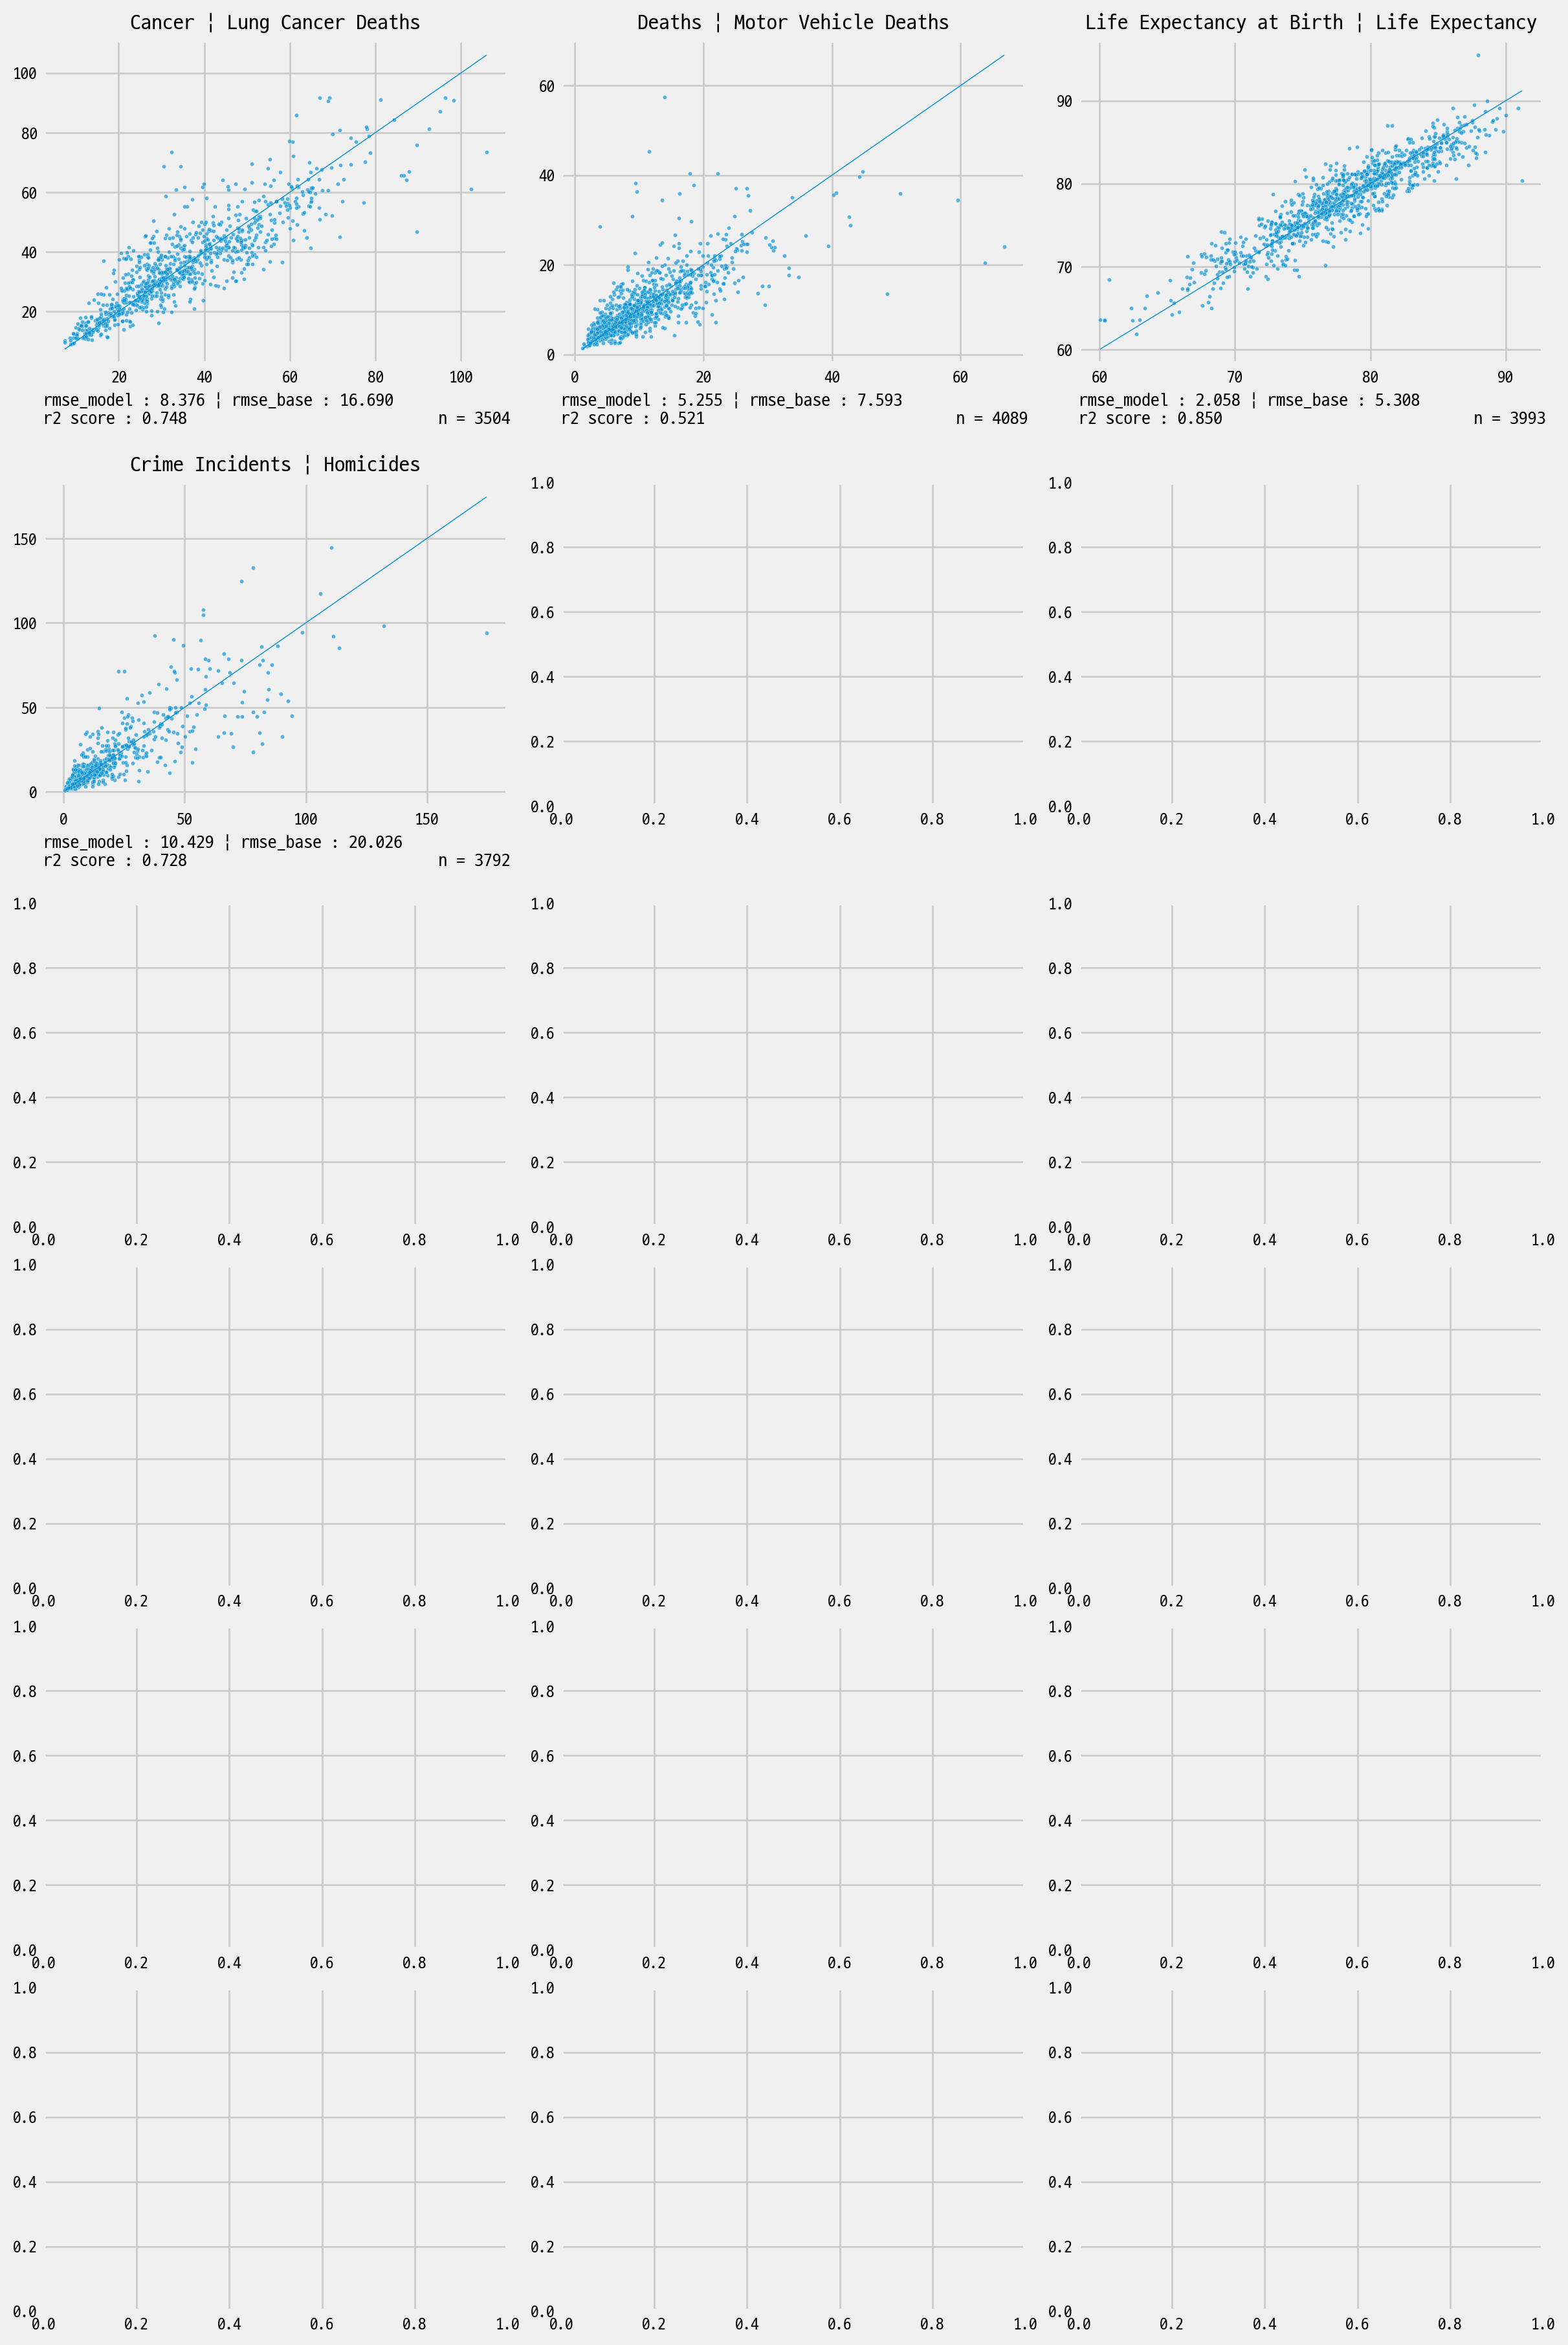

In [70]:
# x = data.iloc[n].index, y = data.iloc[n].values

data_plot ={
    col : (dict_train_test[col][3], dict_rslt[col]['valid'])
    for col in target_sample 
}
data_line = {
    col : (dict_train_test[col][3],dict_train_test[col][3])
    for col in target_sample 
}

fig,axes = plt.subplots(6,3,figsize=(12,18))
fig,axes = pair_plot_feat_hue(fig=fig,axes=axes,data=data_line,
#fig,axes = pair_plot_feat_hue(fig=None,axes=None,data=data_line,
                              pair_plot=sns.lineplot,lw=0.5)
#fig.set_size_inches(12,8, forward=True)
#왠지 모르게 저걸 설정하면 망가짐 
fig,axes = pair_plot_feat_hue(fig=fig,axes=axes,data=data_plot,
                              pair_plot=sns.scatterplot,s=5,alpha=0.65)

for n,key in enumerate(data_plot.keys()):
    ax = axes.flatten()[n]
    ax.set_ylabel('')
    ax.set_title(key,fontsize=12)
    ax.set_xlabel('rmse_model : {:.3f} | rmse_base : {:.3f}\nr2 score : {:.3f} {:>35}\n'.format(*dict_score[key]['rmse'],dict_score[key]['r2_score'][0],
        f'n = {len(dict_train_test[key][0])}'), fontsize=10, ha ='left')

for ax in axes.flatten():
    plt.setp(ax.get_yticklabels(),rotation = 0, fontsize = 9)
    plt.setp(ax.get_xticklabels(),ha ='center',rotation = 0, fontsize = 9)
#    print(ax.get_yticklabels())
#    print('-'*30)

#print(axes.flatten()[2].get_yticklabels())

In [159]:
ax = axes.flatten()[2]
ax.get_yticklabels()

[Text(0, -50.0, '-50'),
 Text(0, 0.0, '0'),
 Text(0, 50.0, '50'),
 Text(0, 100.0, '100'),
 Text(0, 150.0, '150'),
 Text(0, 200.0, '200')]

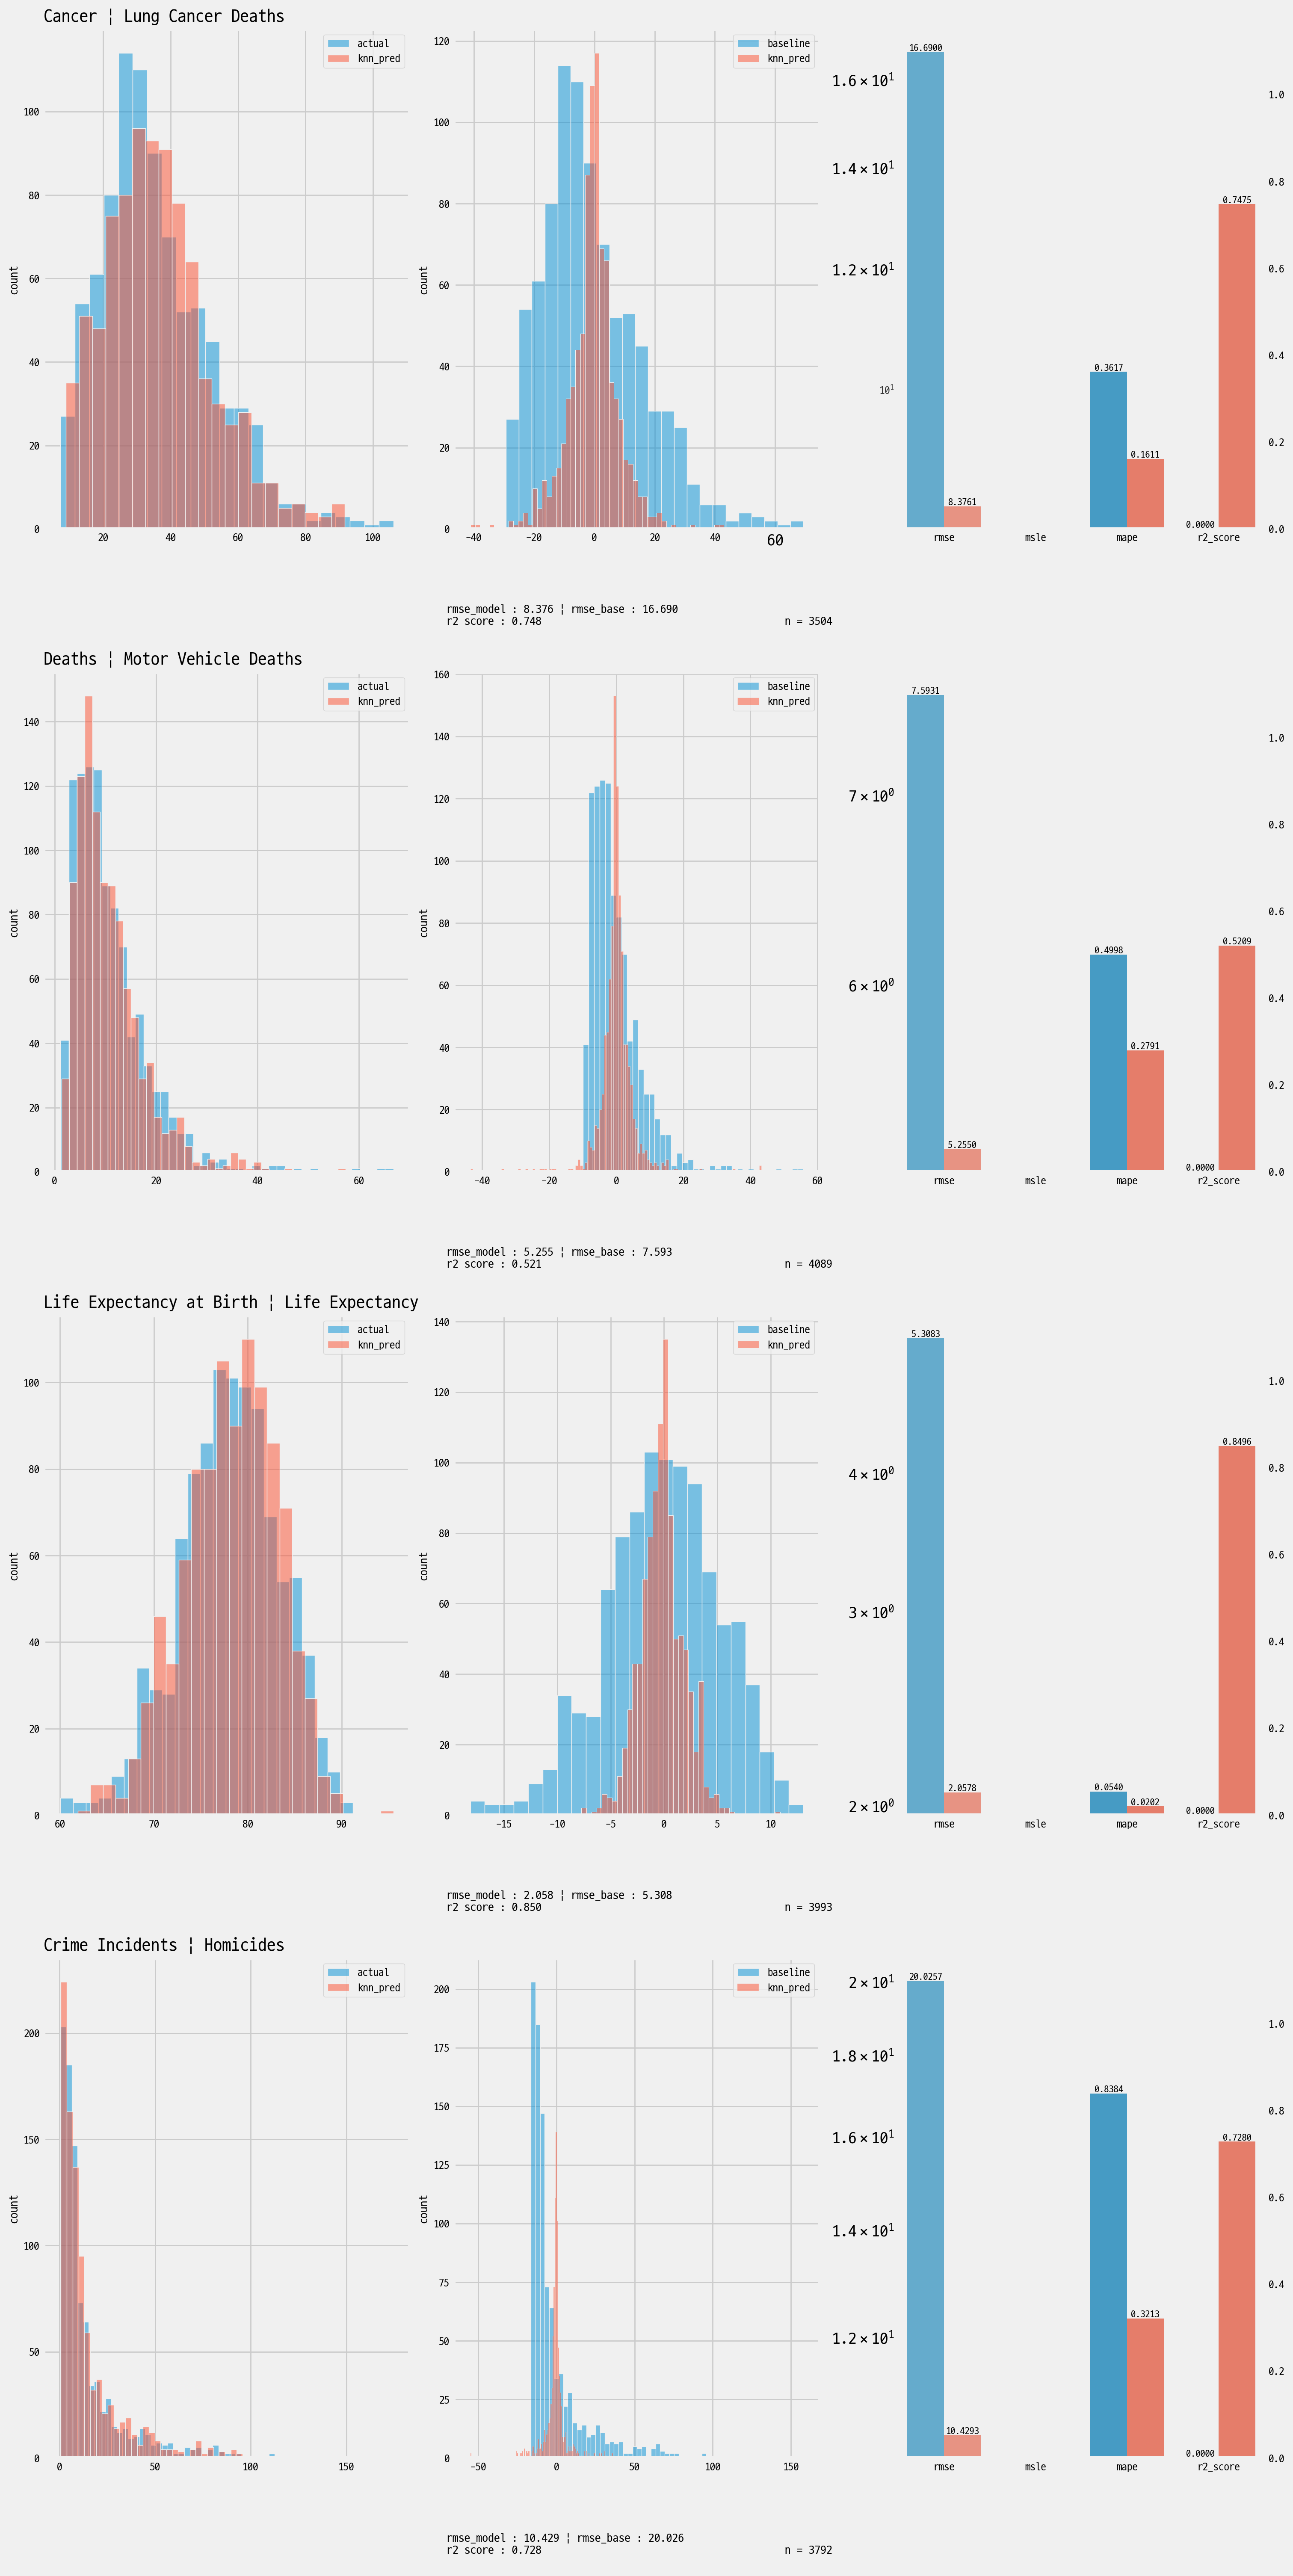

In [71]:
from itertools import repeat, chain

fig,axes = plt.subplots(len(data_plot),3,figsize=(15,30))
for n, col in enumerate(data_plot.keys()):
    #quo, rem = divmod(n,3)
    ax1, ax2, ax3 = axes[n][0], axes[n][1], axes[n][2]
    test_y, y_pred = data_plot[col]
    train_y = dict_train_test[col][2]
    
    sns.histplot(test_y,label='actual',ax=ax1,alpha=0.5)
    sns.histplot(y_pred,label='knn_pred',ax=ax1,alpha=0.5)
    ax1.legend(fontsize=9)
    
    sns.histplot(test_y-np.mean(train_y),ax=ax2, label = 'baseline',alpha=0.5)
    sns.histplot(test_y-y_pred,ax=ax2, label = 'knn_pred',alpha=0.5)
    ax2.legend(fontsize=9)
    
    df_score = pd.DataFrame(dict_score[col]).T[[1,0]]
    xs = list(chain.from_iterable(repeat(val,2) for val in df_score.index))
    ax3r = ax3.twinx()
    sns.barplot(x=xs[:4],y=list(df_score.values.reshape(-1))[:4],
                hue = ['knn_pred','base']*2,ax=ax3,alpha=0.65,legend=False)
    sns.barplot(x=xs[4:],y=list(df_score.values.reshape(-1))[4:],
                hue = ['knn_pred','base']*2,ax=ax3r,alpha=0.8,legend=False)
    ax3.set_yscale('log')
    ax3r.set_ylim([0.0,1.15])
    ax3r.bar_label(ax3r.containers[0], fontsize=8, fmt='%.4f')
    ax3r.bar_label(ax3r.containers[1], fontsize=8, fmt='%.4f')
    ax3.grid(False)
    ax3r.grid(False)
    ax3r.set_yscale('linear')    
    ax3.bar_label(ax3.containers[0], fontsize=8, fmt='%.4f')
    ax3.bar_label(ax3.containers[1], fontsize=8, fmt='%.4f')
    #ax3.axvline()
    
    ax1.set_title(str_cutter(col,50),fontsize=15,loc='left',ha='left')
    ax2.xaxis.set_label_coords(-0.02, -0.15)
    ax2.set_xlabel('rmse_model : {:.3f} | rmse_base : {:.3f}\nr2 score : {:.3f} {:>48}\n'.format(*dict_score[col]['rmse'],dict_score[col]['r2_score'][0],
        f'n = {len(dict_train_test[col][0])}'), fontsize=10,ha ='left')
    #ax2.xaxis.set_label_position('left')
    ax1.set_xlabel('')
    ax3.set_xlabel('')
    ax1.set_ylabel('count',fontsize =10) 
    ax2.set_ylabel('count',fontsize =10) 
    plt.setp(ax3.get_yticklabels(),rotation = 0, fontsize = 9, color='#333333')
    plt.setp(ax3r.get_yticklabels(),rotation = 0, fontsize = 9)

for ax in axes.flatten():
    plt.setp(ax.get_yticklabels(),rotation = 0, fontsize = 9)
    plt.setp(ax.get_xticklabels(),ha ='center',rotation = 0, fontsize = 9)

cf. 누락율이 꽤나 높음에도 예상보다 잘 맞춤
- 단 해당 칼럼들은 race-sex집단에서 stratified 된 집단이 각 도시/연도 별로 최소 하나는 있는 도시/연도가 50% 이상임
- 위의 비율 기준, 118개 중 상위 30 ~ 44 위의 label들 (100% ~ 53.8%)
- 45위 부터는 25% 미만으로 떨어짐

    (구체적 내용 : 240619_check_missing_entire.ipynb)
- 현재 연도를 많이 보지 않으니, 도시 기준으로 분포하는 비율을 봐서, 추가적인 후보를 추릴 수 있을 것 같음

## fill with rslt of knn

In [163]:
dict_rslt

{'Deaths | Racial Disparity in Police Killings': {'target': array([1.75218736, 1.75218736, 1.75218736, ..., 1.11208108, 1.10190746,
         1.10190746]),
  'valid': array([ 1.3695688 ,  1.82834552, -0.75527731,  7.76990686,  1.82834552,
          3.16293325, 10.25772942,  1.3695688 ,  1.82834552,  0.15010784,
          1.43953721,  3.16293325,  2.23652755,  3.16293325,  1.82816581,
          1.3695688 ,  0.67364898,  2.23652755,  4.19957335,  1.43953721,
          3.16293325,  2.23652755,  0.39247757,  3.16293325,  1.82834552,
          3.74044126,  1.82834552,  1.82834552,  3.16293325,  0.34381903,
          2.23652755,  1.82834552,  2.23652755,  3.16293325,  0.34381903,
          3.16293325,  1.3695688 ,  2.23652755,  3.16293325,  3.16293325,
          1.82834552,  1.82816581,  4.95359447,  0.67364898,  1.43953721,
          1.43953721,  3.36234543,  0.39247757,  1.3695688 ,  1.3695688 ,
          1.82834552,  1.3695688 ,  3.16293325,  3.74044126,  2.23652755,
          3.74044126, 

In [167]:
rslt_form = test_df[info_cols+target_sample]
rslt_form.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7280 entries, 0 to 7279
Data columns (total 16 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   city_idx                                         7280 non-null   int64  
 1   encoded_strata_race_label                        7280 non-null   int64  
 2   encoded_strata_sex_label                         7280 non-null   int64  
 3   encoded_geo_strata_region                        7280 non-null   int64  
 4   encoded_geo_strata_poverty                       7280 non-null   int64  
 5   encoded_geo_strata_Population                    7280 non-null   int64  
 6   encoded_geo_strata_PopDensity                    7280 non-null   int64  
 7   encoded_geo_strata_Segregation                   7280 non-null   int64  
 8   date_label                                       7280 non-null   int64  
 9   Deaths | Racial Disparity in Police

In [177]:
for col in target_sample:
    cond = dict_df[col]['target'][1]
    rslt_form.loc[cond,col] = dict_rslt[col]['target']

rslt_form.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7280 entries, 0 to 7279
Data columns (total 16 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   city_idx                                         7280 non-null   int64  
 1   encoded_strata_race_label                        7280 non-null   int64  
 2   encoded_strata_sex_label                         7280 non-null   int64  
 3   encoded_geo_strata_region                        7280 non-null   int64  
 4   encoded_geo_strata_poverty                       7280 non-null   int64  
 5   encoded_geo_strata_Population                    7280 non-null   int64  
 6   encoded_geo_strata_PopDensity                    7280 non-null   int64  
 7   encoded_geo_strata_Segregation                   7280 non-null   int64  
 8   date_label                                       7280 non-null   int64  
 9   Deaths | Racial Disparity in Police

In [178]:
file_name = 'pvtb_filled_knn_{}_{}.csv'.format(work_idx,10)
save_dir = os.path.join(RSLT_DIR,knn_dir,'PROCESSED')
if not os.path.exists(save_dir): os.mkdir(save_dir)
rslt_form.to_csv(os.path.join(save_dir,file_name))

### load intermediate pkl files and finish the process

In [181]:
import os, pickle

In [198]:
display(info_cols)
test_df.head()

['city_idx',
 'encoded_strata_race_label',
 'encoded_strata_sex_label',
 'encoded_geo_strata_region',
 'encoded_geo_strata_poverty',
 'encoded_geo_strata_Population',
 'encoded_geo_strata_PopDensity',
 'encoded_geo_strata_Segregation',
 'date_label']

,city_idx,encoded_strata_race_label,encoded_strata_sex_label,encoded_geo_strata_region,encoded_geo_strata_poverty,encoded_geo_strata_Population,encoded_geo_strata_PopDensity,encoded_geo_strata_Segregation,date_label,Heat and Disasters | Community Social Vulnerability to Climate Disasters,...,Births | Teen Births,"Health Insurance | Uninsured, Child","Racial Segregation Indices | Racial Segregation, White and Black",Cancer | Breast Cancer Deaths,Substance Use | Opioid Overdose Deaths,Respiratory Infection | COVID-19 Deaths,Income | Per-capita Household Income,"Racial Segregation Indices | Racial Segregation, White and Non-White",Heat and Disasters | Longer Summers,Income-related | Unemployment
0,20,0,0,2,1,0,0,0,2010,28.323699,...,46.316886,NaN,57.924125,19.970689,5.316296,NaN,31387.0,44.163428,50.902381,7.334556
1,20,0,1,2,1,0,0,0,2010,NaN,...,NaN,NaN,NaN,NaN,4.224056,NaN,NaN,NaN,NaN,NaN
2,20,0,2,2,1,0,0,0,2010,NaN,...,NaN,NaN,NaN,NaN,6.417004,NaN,NaN,NaN,NaN,NaN
3,20,4,0,2,1,0,0,0,2010,NaN,...,5.460005,NaN,NaN,NaN,NaN,NaN,31998.0,NaN,NaN,6.419018
4,20,4,1,2,1,0,0,0,2010,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
knn_path = os.path.join(RSLT_DIR,knn_dir)
os.listdir(knn_path)

['dict_knn_0_10.pkl:Zone.Identifier',
 'dict_train_test_2_10.pkl:Zone.Identifier',
 'dict_rslt_2_10.pkl',
 'dict_train_test_0_10.pkl',
 'dict_knn_2_10.pkl:Zone.Identifier',
 'dict_rslt_1_10.pkl',
 'dict_knn_1_10.pkl',
 'dict_train_test_2_10.pkl',
 'dict_knn_2_10.pkl',
 'dict_rslt_2_10.pkl:Zone.Identifier',
 'dict_knn_0_10.pkl',
 'dict_rslt_0_10.pkl:Zone.Identifier',
 'dict_train_test_1_10.pkl',
 'PROCESSED',
 'dict_rslt_0_10.pkl',
 'dict_train_test_0_10.pkl:Zone.Identifier']

In [228]:
work_idx = 2
work_name = '{}_10'.format(work_idx)

files = list(filter(lambda x : work_name in x,os.listdir(knn_path)))
file_dict = dict()
for filename in files:
    if filename[-4:] != '.pkl' : continue
    if 'knn' in filename : continue
    print(filename)
    file_path = os.path.join(knn_path,filename)
    with open (file_path,'rb') as f:
        file_dict[filename[:-5-len(work_name)]] = pickle.load(f)

file_dict.keys()

dict_rslt_2_10.pkl
dict_train_test_2_10.pkl


dict_keys(['dict_rslt', 'dict_train_test'])

In [229]:
dict_rslt = file_dict['dict_rslt']
target_sample= list(dict_rslt.keys())

In [230]:
rslt_form = test_df[info_cols+target_sample]
rslt_form.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7280 entries, 0 to 7279
Data columns (total 16 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   city_idx                                  7280 non-null   int64  
 1   encoded_strata_race_label                 7280 non-null   int64  
 2   encoded_strata_sex_label                  7280 non-null   int64  
 3   encoded_geo_strata_region                 7280 non-null   int64  
 4   encoded_geo_strata_poverty                7280 non-null   int64  
 5   encoded_geo_strata_Population             7280 non-null   int64  
 6   encoded_geo_strata_PopDensity             7280 non-null   int64  
 7   encoded_geo_strata_Segregation            7280 non-null   int64  
 8   date_label                                7280 non-null   int64  
 9   Deaths | Maternal Deaths                  1001 non-null   float64
 10  Food Access | Limited Supermarket Access 

In [231]:
for col in target_sample:
    cond = test_df[col].isna()
    loaded = dict_rslt[col]['target']
    assert np.sum(cond) == len(loaded)  
    rslt_form.loc[cond,col] = loaded

rslt_form.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7280 entries, 0 to 7279
Data columns (total 16 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   city_idx                                  7280 non-null   int64  
 1   encoded_strata_race_label                 7280 non-null   int64  
 2   encoded_strata_sex_label                  7280 non-null   int64  
 3   encoded_geo_strata_region                 7280 non-null   int64  
 4   encoded_geo_strata_poverty                7280 non-null   int64  
 5   encoded_geo_strata_Population             7280 non-null   int64  
 6   encoded_geo_strata_PopDensity             7280 non-null   int64  
 7   encoded_geo_strata_Segregation            7280 non-null   int64  
 8   date_label                                7280 non-null   int64  
 9   Deaths | Maternal Deaths                  7280 non-null   float64
 10  Food Access | Limited Supermarket Access 

In [214]:
file_name = 'pvtb_filled_knn_{}_{}.csv'.format(work_idx,10)
save_dir = os.path.join(RSLT_DIR,knn_dir,'PROCESSED')
if not os.path.exists(save_dir): os.mkdir(save_dir)
rslt_form.to_csv(os.path.join(save_dir,file_name))

#### check score for loaded data

In [232]:
dict_rslt=file_dict['dict_rslt']
dict_train_test=file_dict['dict_train_test']

In [233]:
dict_df = dict()

for col in target_cols:
    temp = test_df[info_cols+[col]]
    cond_na = temp.isna().any(axis=1)
    dict_df[col] = {
        'train' : [temp.loc[~cond_na,info_cols], temp.loc[~cond_na,col]],
        'target' : [temp.loc[cond_na,info_cols], cond_na],
    }

In [234]:
dict_score = dict()

for col in target_sample:
    train_X, train_y = dict_df[col]['train']
    _,valid_X,_,valid_y = dict_train_test[col]
    y_pred = dict_rslt[col]['valid']
    rmse_model = np.sqrt(mse(y_pred,valid_y))
    rmse_base = np.sqrt(mse([train_y.mean()]*len(valid_y),valid_y))
    msle_model = 0 #msle(valid_y,y_pred) : negtive value error occurs but i don't know why
    msle_base = 0 #msle(valid_y,[train_y.mean()]*len(valid_y)) :
    mape_model = (mape(y_pred,valid_y))
    mape_base = mape([train_y.mean()]*len(valid_y),valid_y)
    r2_model = r2_score(valid_y,y_pred)
    r2_base = 0 
    dict_score[col] = {
        'rmse' : [rmse_model, rmse_base],
        'msle' : [msle_model, msle_base],
        'mape' : [mape_model, mape_base],
        'r2_score' : [r2_model,r2_base]
    }
    print('{}\nr2 score : {:.5f}'.format(col,r2_model))
    print('rmse_model : {:.5f} / rmse_base : {:.5f}\t'.format(*dict_score[col]['rmse']),
          'mape_model : {:.5f} / mape_base : {:.5f}\t'.format(*dict_score[col]['mape']),
          'msle_model : {:.5f} / msle_base : {:.5f}'.format(*dict_score[col]['msle']))
    print('-'*150)

Deaths | Maternal Deaths
r2 score : 0.80720
rmse_model : 6.65786 / rmse_base : 15.17800	 mape_model : 0.15071 / mape_base : 0.41375	 msle_model : 0.00000 / msle_base : 0.00000
------------------------------------------------------------------------------------------------------------------------------------------------------
Food Access | Limited Supermarket Access
r2 score : 0.81463
rmse_model : 7.25285 / rmse_base : 16.91709	 mape_model : 0.10066 / mape_base : 0.32568	 msle_model : 0.00000 / msle_base : 0.00000
------------------------------------------------------------------------------------------------------------------------------------------------------
Housing | Homeless, Children
r2 score : 0.77140
rmse_model : 3.41718 / rmse_base : 7.14767	 mape_model : 0.13661 / mape_base : 0.30684	 msle_model : 0.00000 / msle_base : 0.00000
------------------------------------------------------------------------------------------------------------------------------------------------------


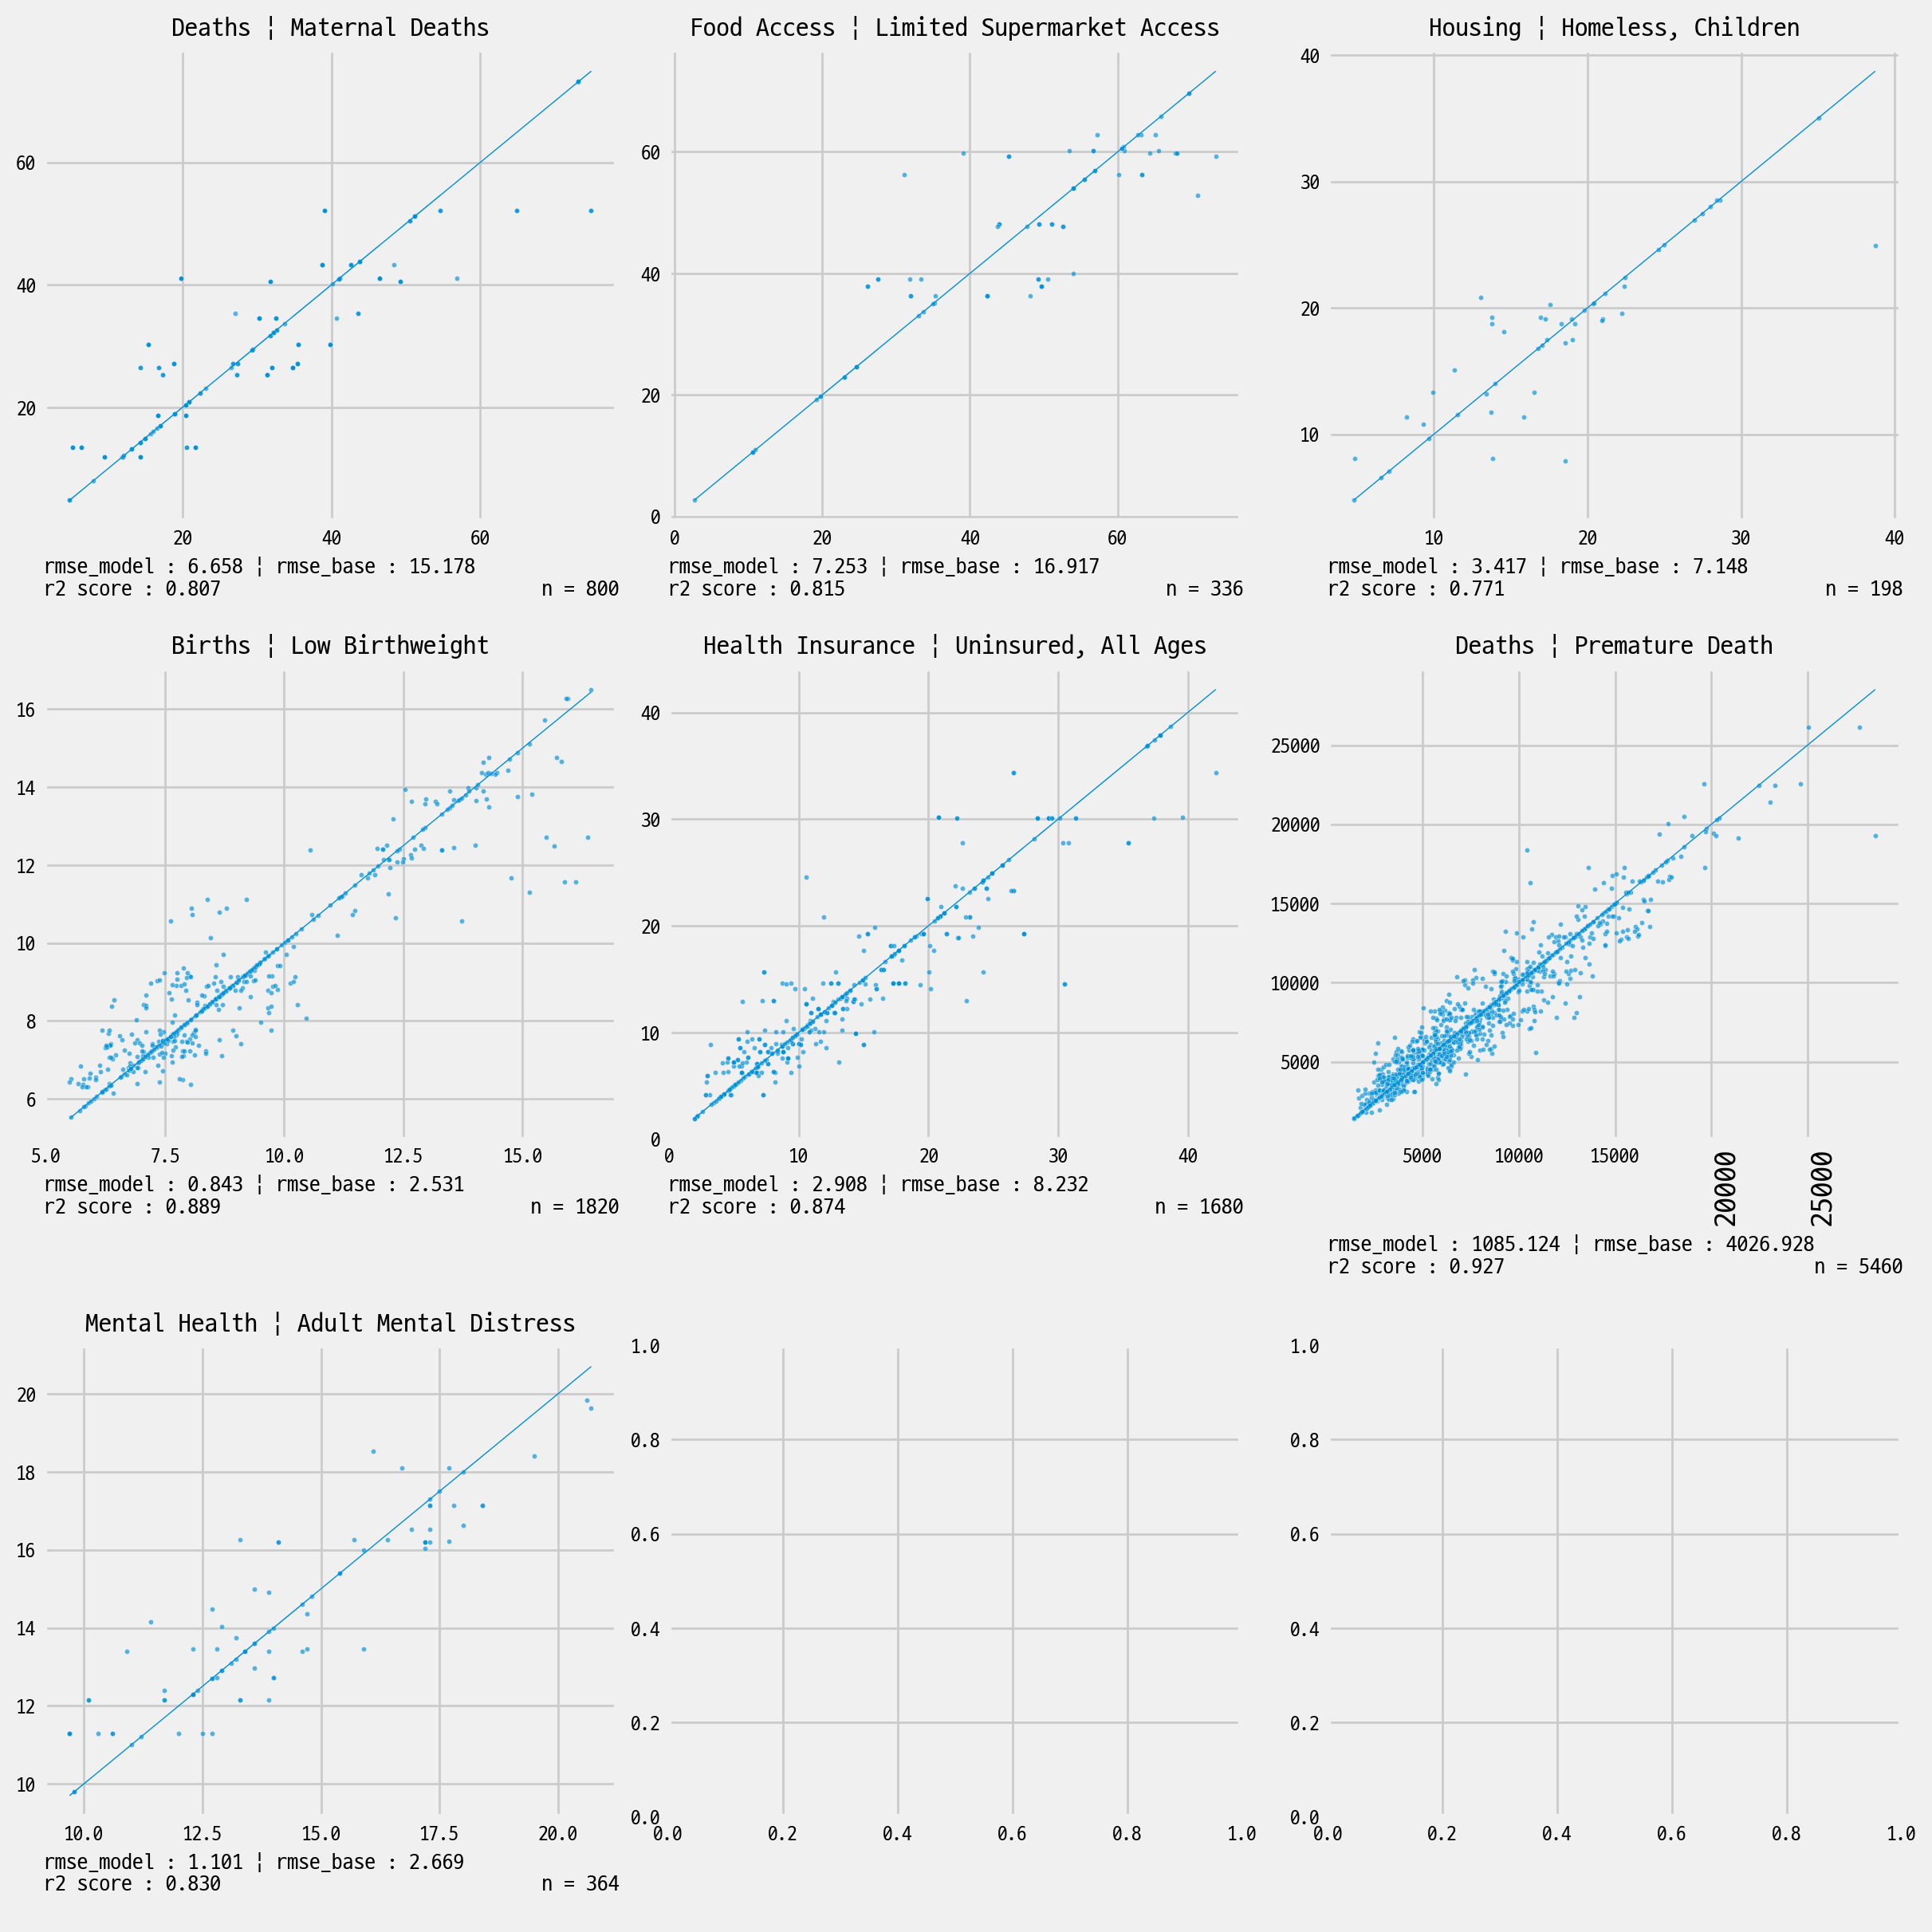

In [235]:
# x = data.iloc[n].index, y = data.iloc[n].values

data_plot ={
    col : (dict_train_test[col][3], dict_rslt[col]['valid'])
    for col in target_sample 
}
data_line = {
    col : (dict_train_test[col][3],dict_train_test[col][3])
    for col in target_sample 
}

fig,axes = plt.subplots(3,3,figsize=(12,12))
fig,axes = pair_plot_feat_hue(fig=fig,axes=axes,data=data_line,
#fig,axes = pair_plot_feat_hue(fig=None,axes=None,data=data_line,
                              pair_plot=sns.lineplot,lw=0.5)
#fig.set_size_inches(12,8, forward=True)
#왠지 모르게 저걸 설정하면 망가짐 
fig,axes = pair_plot_feat_hue(fig=fig,axes=axes,data=data_plot,
                              pair_plot=sns.scatterplot,s=5,alpha=0.65)

for n,key in enumerate(data_plot.keys()):
    ax = axes.flatten()[n]
    ax.set_ylabel('')
    ax.set_title(key,fontsize=12)
    ax.set_xlabel('rmse_model : {:.3f} | rmse_base : {:.3f}\nr2 score : {:.3f} {:>35}\n'.format(*dict_score[key]['rmse'],dict_score[key]['r2_score'][0],
        f'n = {len(dict_train_test[key][0])}'), fontsize=10, ha ='left')

for ax in axes.flatten():
    plt.setp(ax.get_yticklabels(),rotation = 0, fontsize = 9)
    plt.setp(ax.get_xticklabels(),ha ='center',rotation = 0, fontsize = 9)
#    print(ax.get_yticklabels())
#    print('-'*30)

#print(axes.flatten()[2].get_yticklabels())

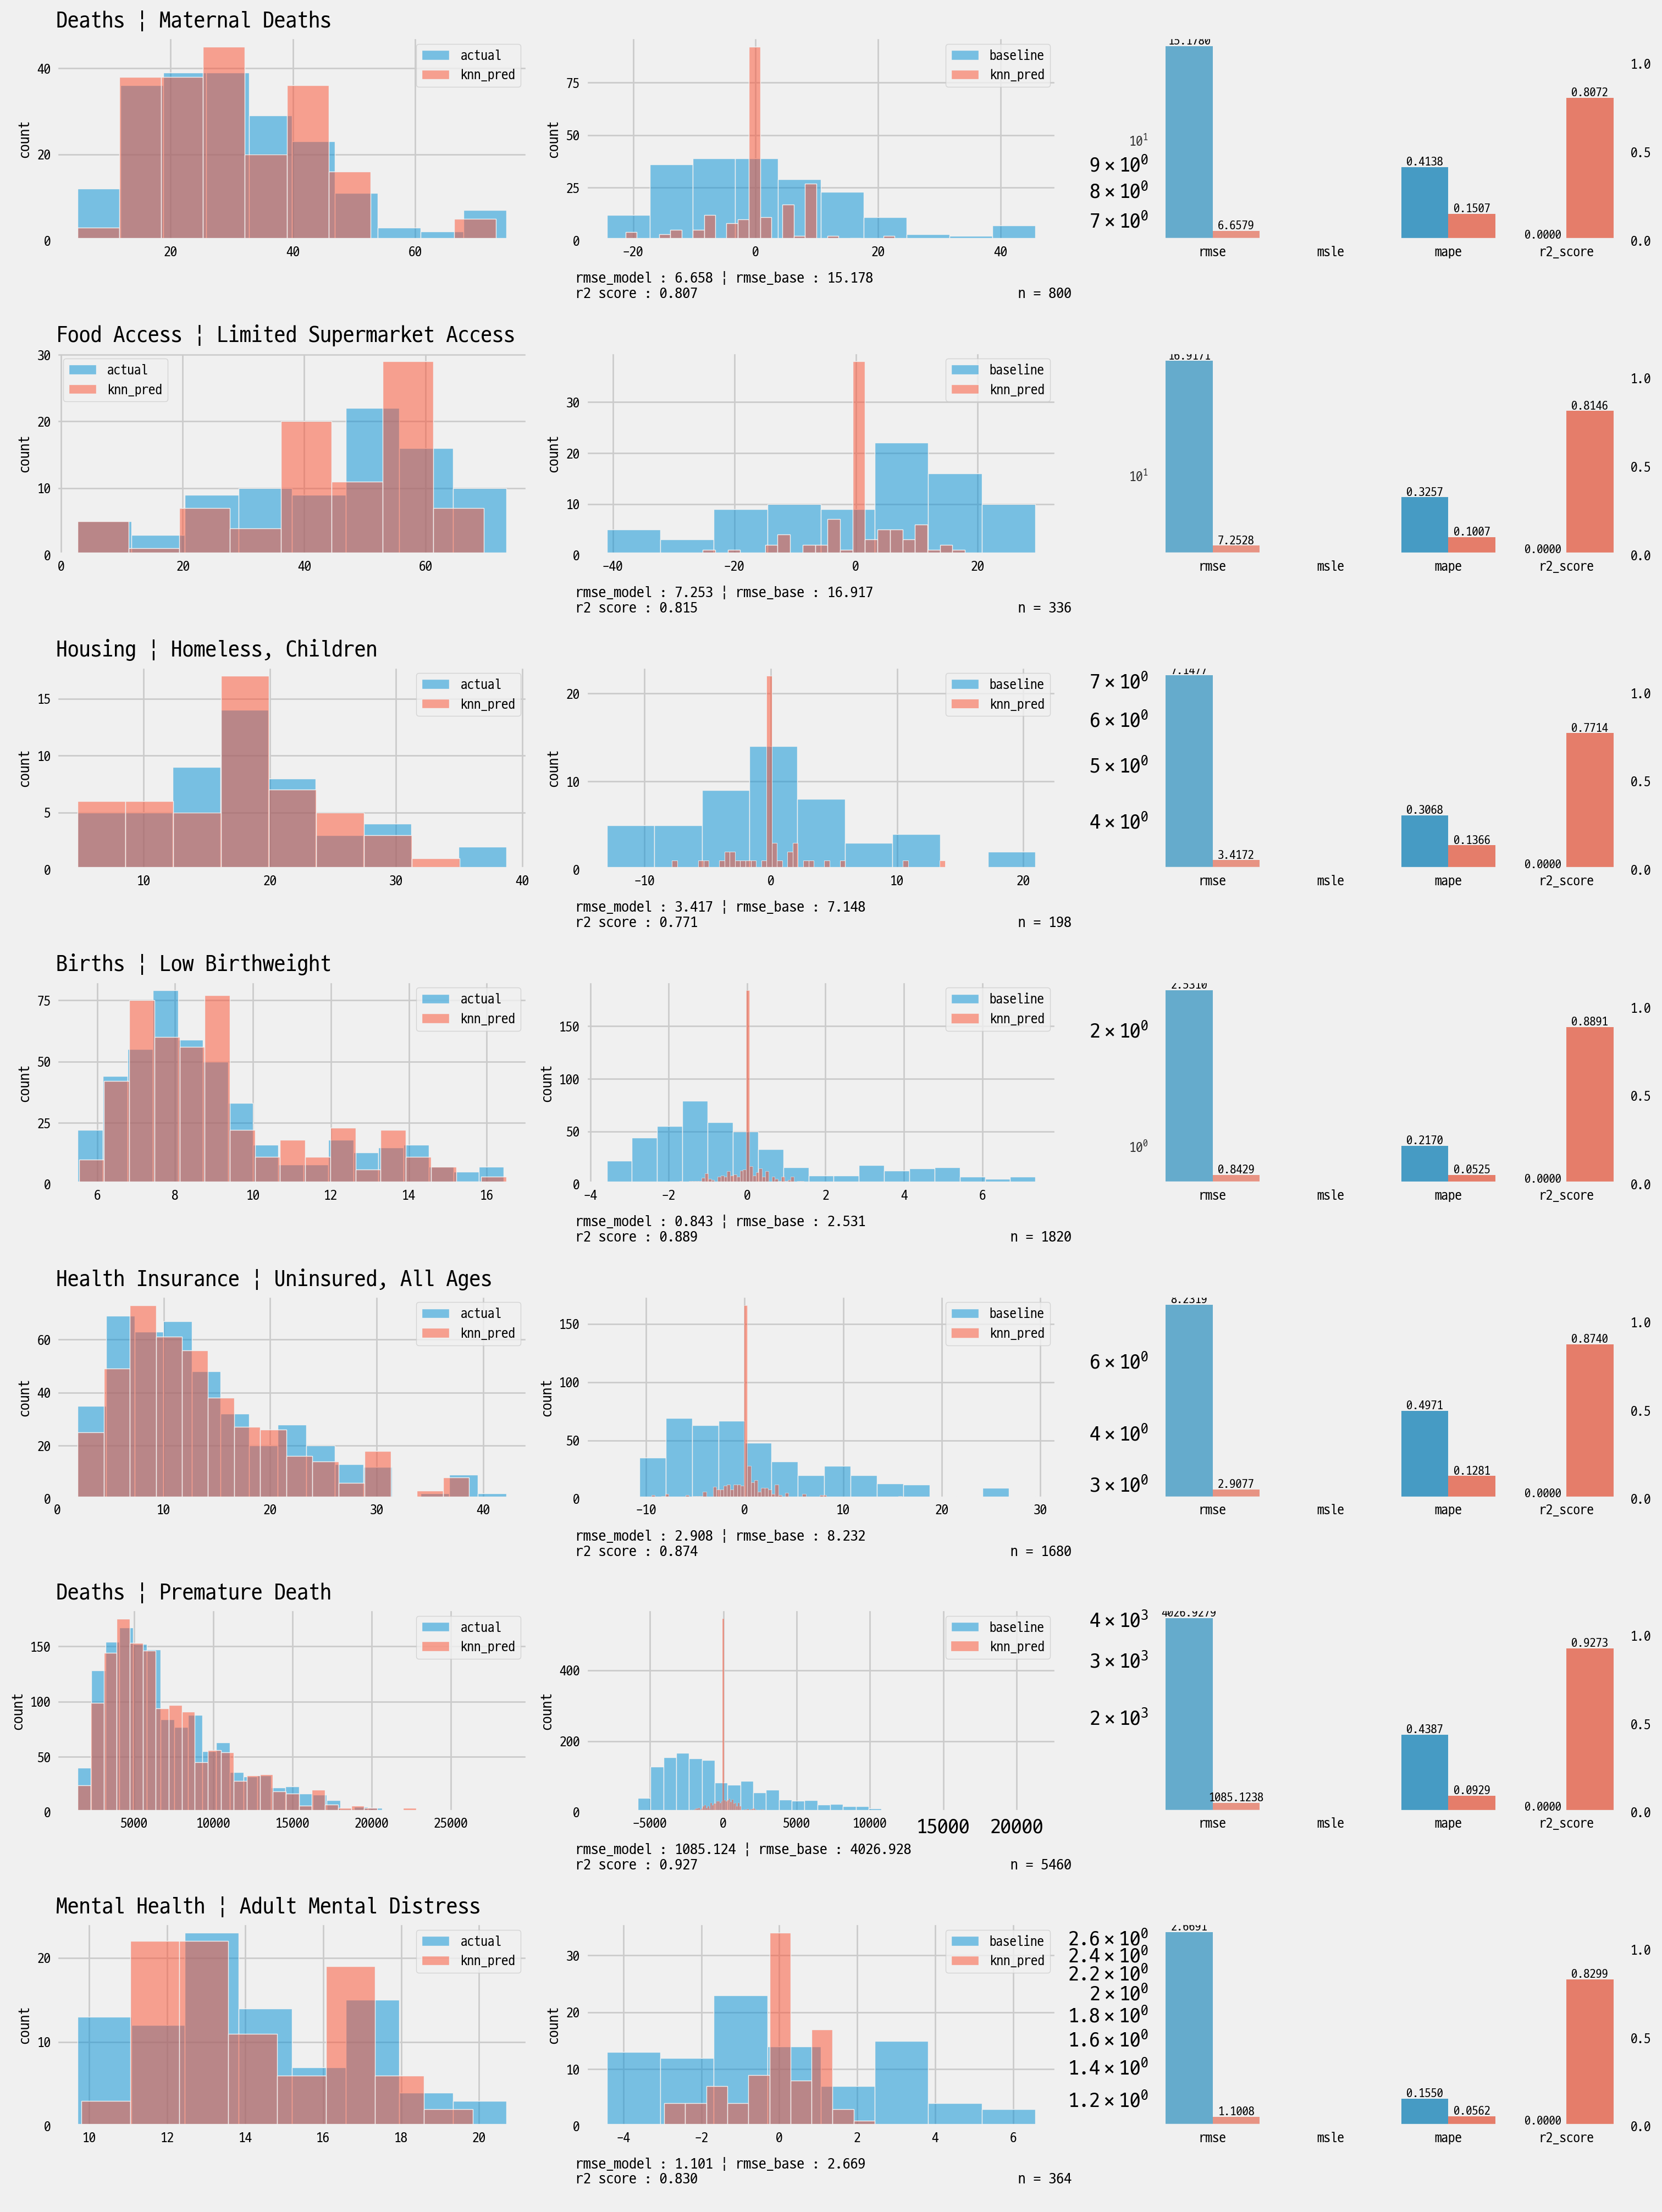

In [236]:
from itertools import repeat, chain

fig,axes = plt.subplots(len(data_plot),3,figsize=(15,20))
for n, col in enumerate(data_plot.keys()):
    #quo, rem = divmod(n,3)
    ax1, ax2, ax3 = axes[n][0], axes[n][1], axes[n][2]
    test_y, y_pred = data_plot[col]
    train_y = dict_train_test[col][2]
    
    sns.histplot(test_y,label='actual',ax=ax1,alpha=0.5)
    sns.histplot(y_pred,label='knn_pred',ax=ax1,alpha=0.5)
    ax1.legend(fontsize=9)
    
    sns.histplot(test_y-np.mean(train_y),ax=ax2, label = 'baseline',alpha=0.5)
    sns.histplot(test_y-y_pred,ax=ax2, label = 'knn_pred',alpha=0.5)
    ax2.legend(fontsize=9)
    
    df_score = pd.DataFrame(dict_score[col]).T[[1,0]]
    xs = list(chain.from_iterable(repeat(val,2) for val in df_score.index))
    ax3r = ax3.twinx()
    sns.barplot(x=xs[:4],y=list(df_score.values.reshape(-1))[:4],
                hue = ['knn_pred','base']*2,ax=ax3,alpha=0.65,legend=False)
    sns.barplot(x=xs[4:],y=list(df_score.values.reshape(-1))[4:],
                hue = ['knn_pred','base']*2,ax=ax3r,alpha=0.8,legend=False)
    ax3.set_yscale('log')
    ax3r.set_ylim([0.0,1.15])
    ax3r.bar_label(ax3r.containers[0], fontsize=8, fmt='%.4f')
    ax3r.bar_label(ax3r.containers[1], fontsize=8, fmt='%.4f')
    ax3.grid(False)
    ax3r.grid(False)
    ax3r.set_yscale('linear')    
    ax3.bar_label(ax3.containers[0], fontsize=8, fmt='%.4f')
    ax3.bar_label(ax3.containers[1], fontsize=8, fmt='%.4f')
    #ax3.axvline()
    
    ax1.set_title(str_cutter(col,50),fontsize=15,loc='left',ha='left')
    ax2.xaxis.set_label_coords(-0.02, -0.15)
    ax2.set_xlabel('rmse_model : {:.3f} | rmse_base : {:.3f}\nr2 score : {:.3f} {:>48}\n'.format(*dict_score[col]['rmse'],dict_score[col]['r2_score'][0],
        f'n = {len(dict_train_test[col][0])}'), fontsize=10,ha ='left')
    #ax2.xaxis.set_label_position('left')
    ax1.set_xlabel('')
    ax3.set_xlabel('')
    ax1.set_ylabel('count',fontsize =10) 
    ax2.set_ylabel('count',fontsize =10) 
    plt.setp(ax3.get_yticklabels(),rotation = 0, fontsize = 9, color='#333333')
    plt.setp(ax3r.get_yticklabels(),rotation = 0, fontsize = 9)

for ax in axes.flatten():
    plt.setp(ax.get_yticklabels(),rotation = 0, fontsize = 9)
    plt.setp(ax.get_xticklabels(),ha ='center',rotation = 0, fontsize = 9)